In [350]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.io import loadmat 
from scipy.stats import spearmanr
import pickle 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from utils.data import make_dataset
from parameters import parser
from utils.eval import compute_sparsity_stats
import torch
from scipy import stats 
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


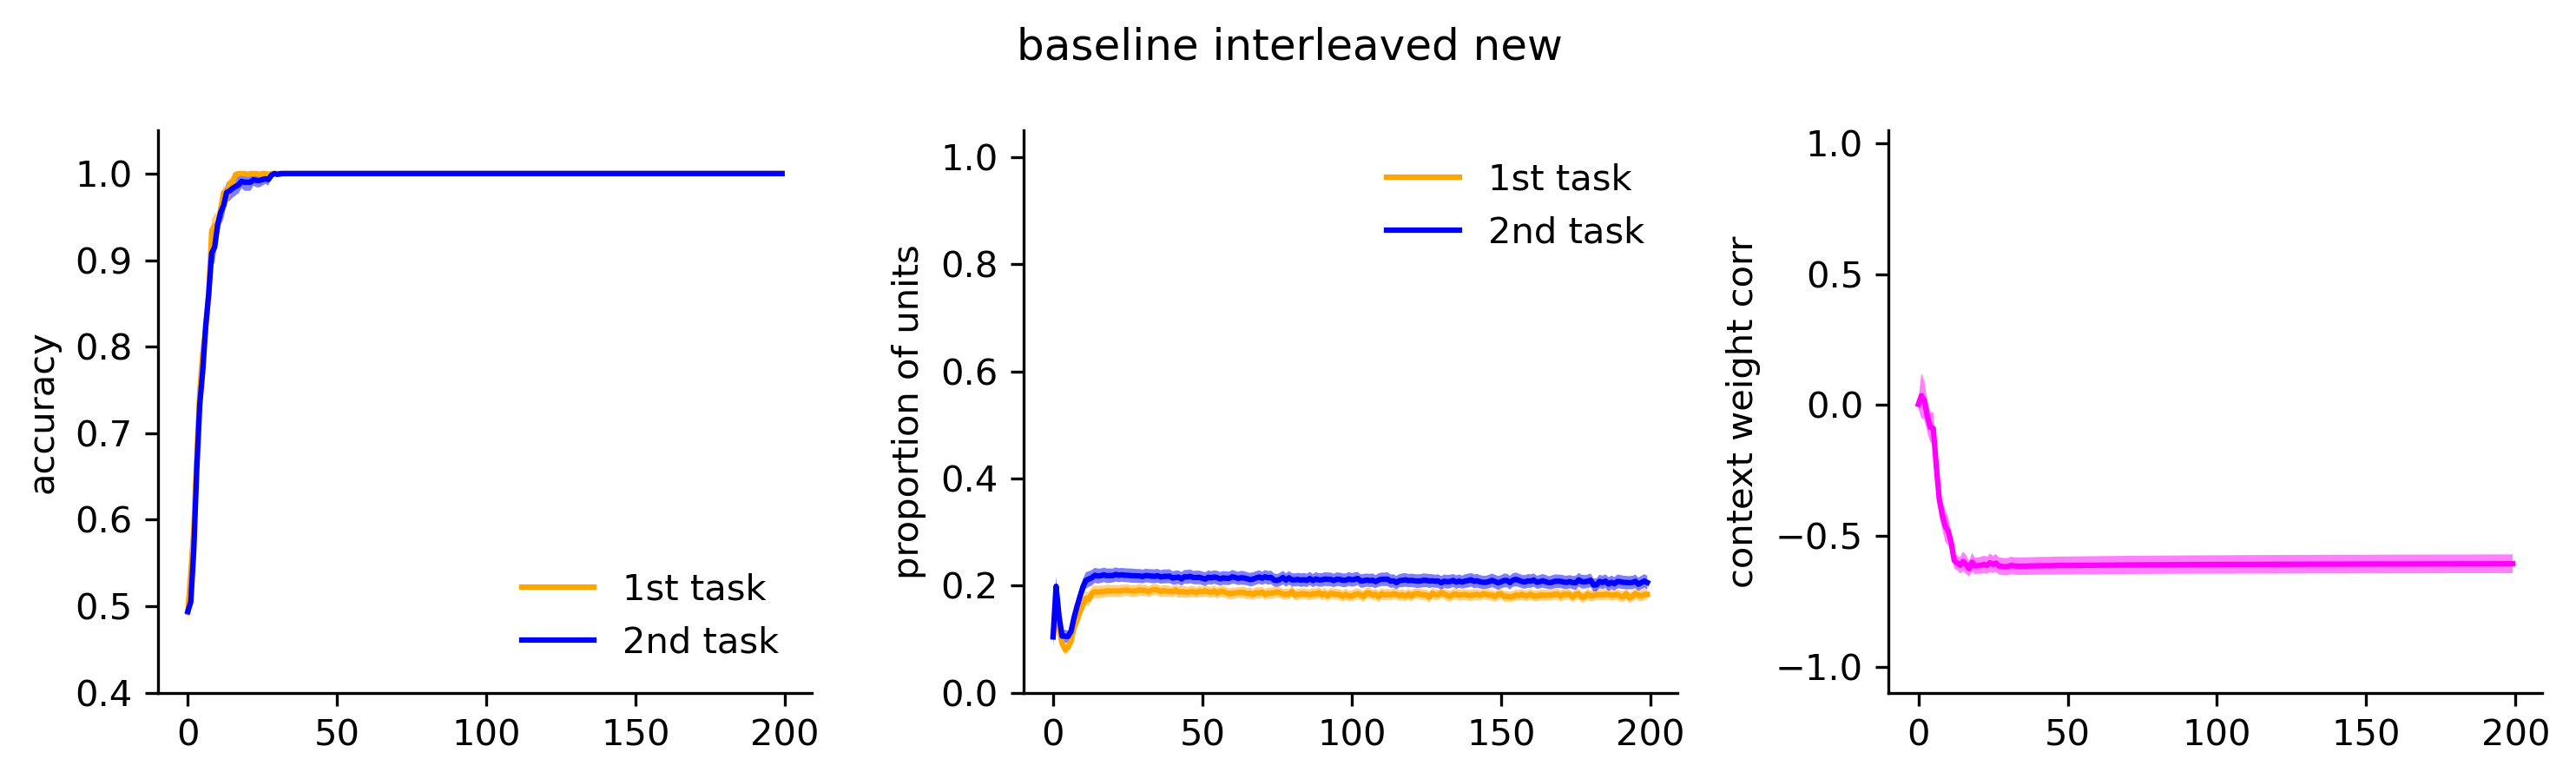

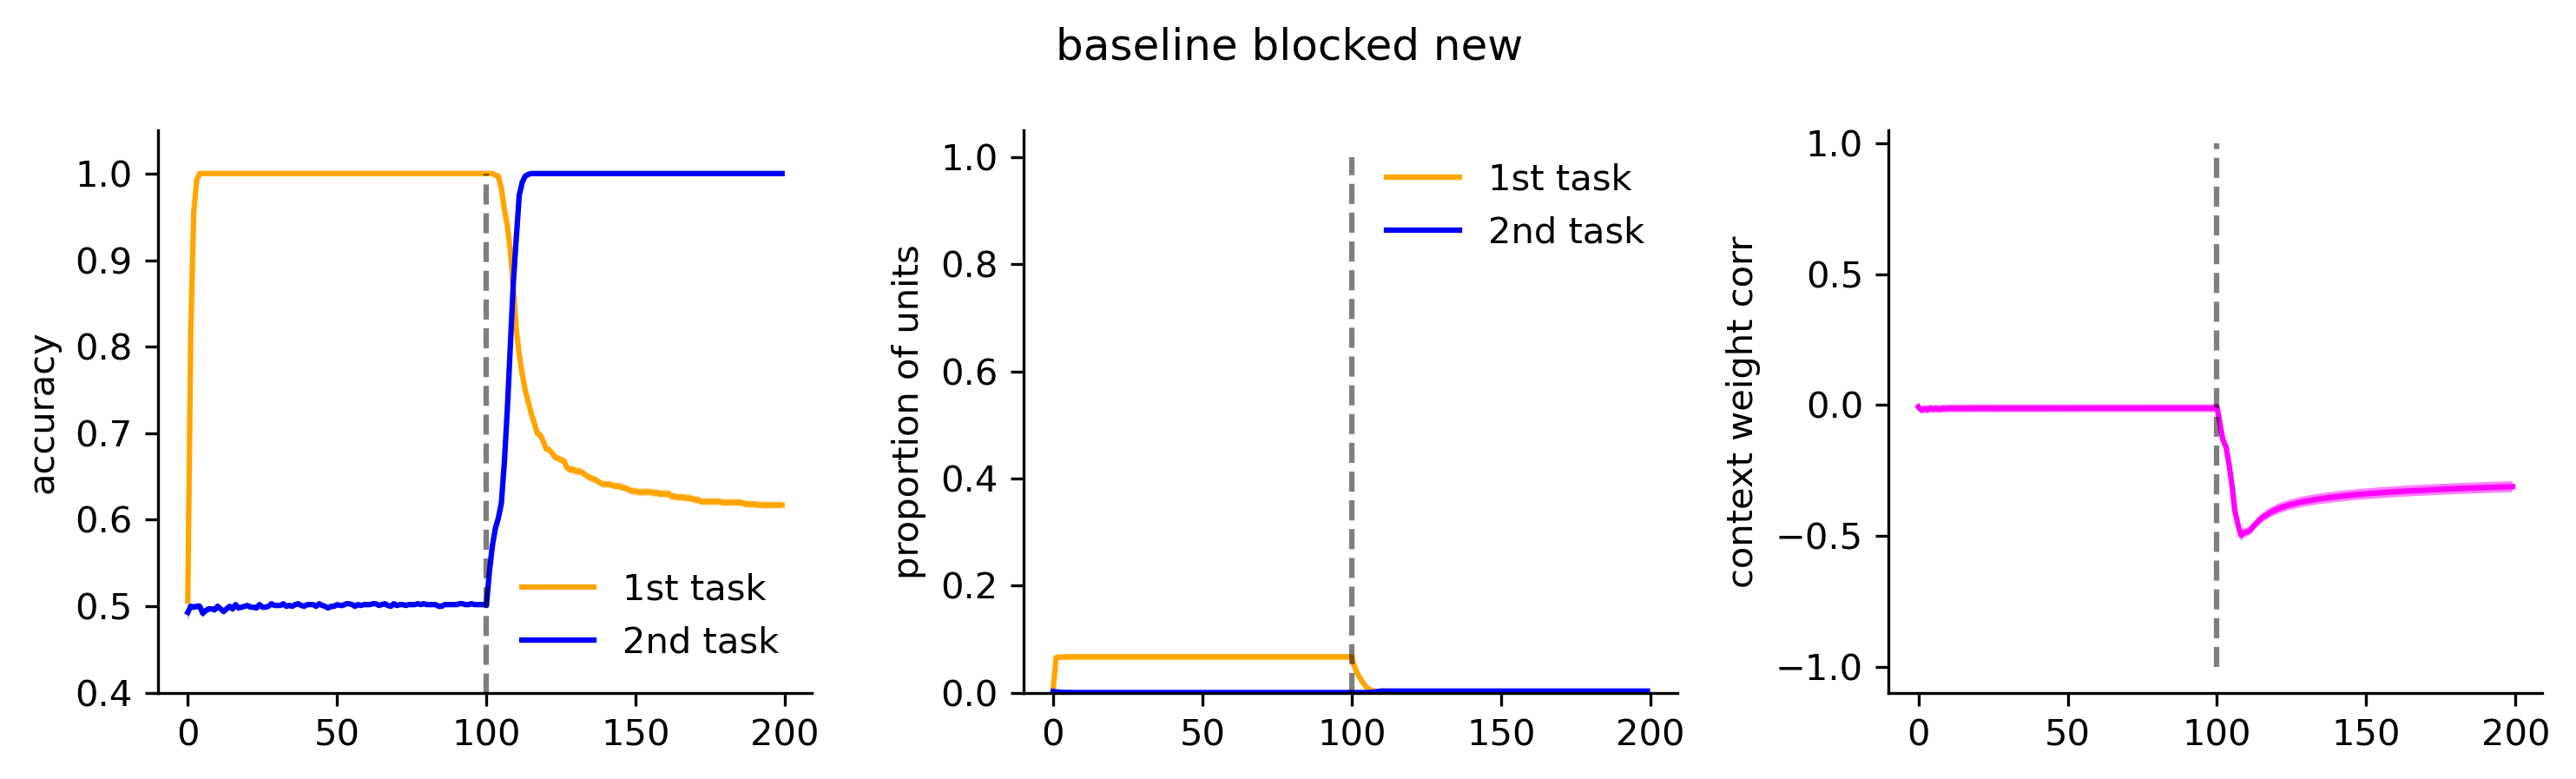

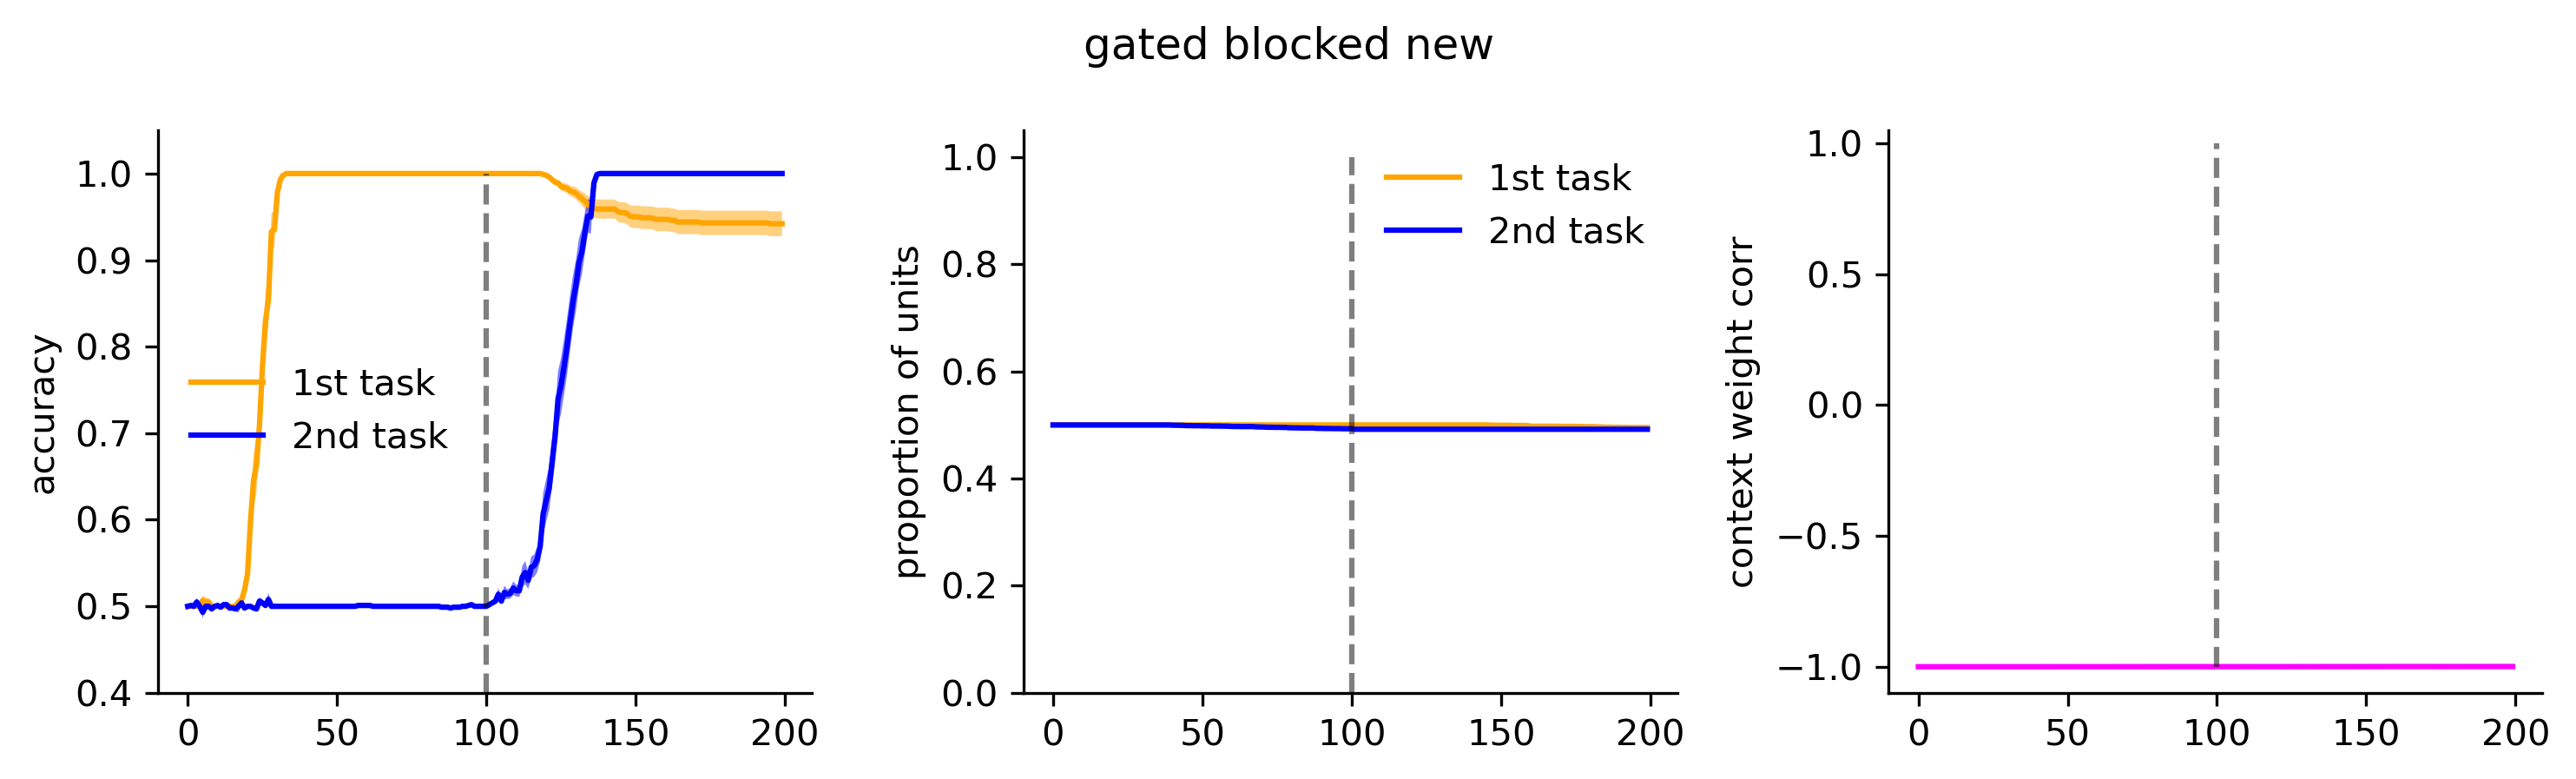

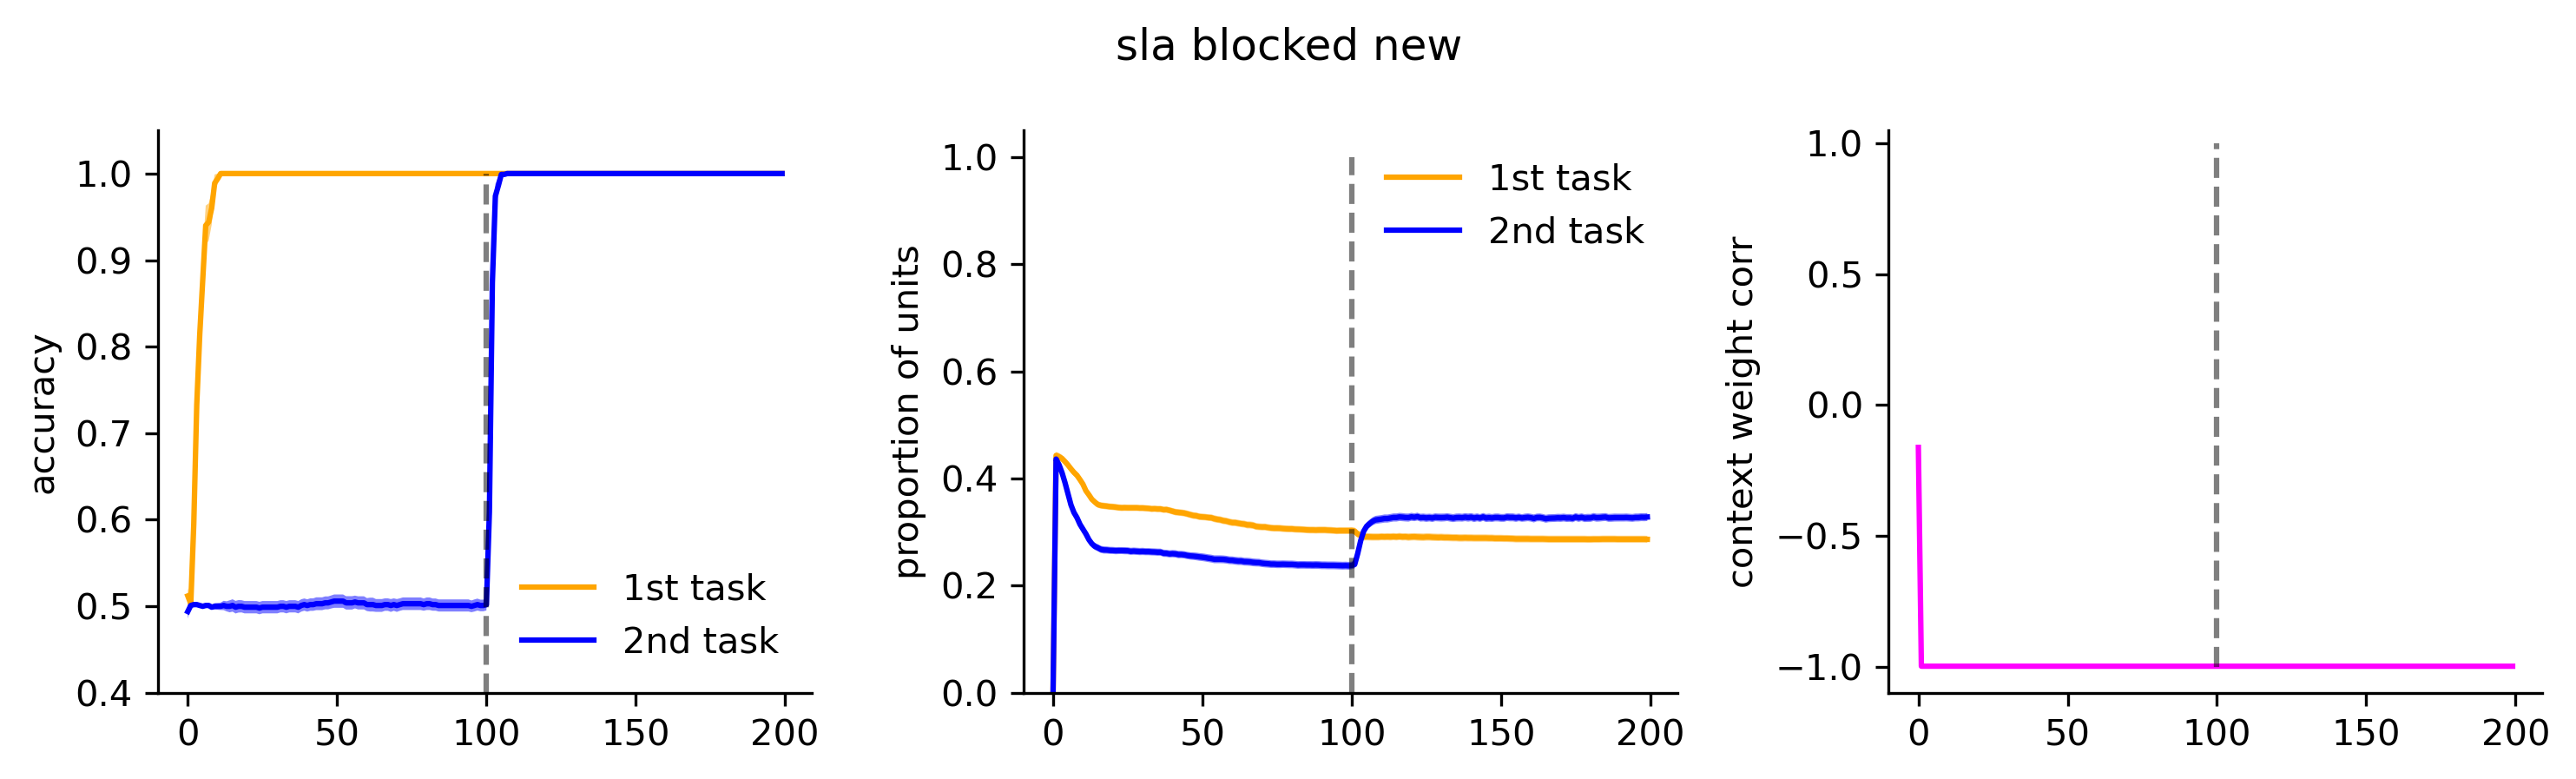

In [65]:
n_runs = 50
models = ['baseline_interleaved_new', 'baseline_blocked_new',
          'gated_blocked_new', 'sla_blocked_new']

for i,m in enumerate(models):
    f, axs = plt.subplots(1,3,figsize=(10,3),dpi=300)
    t_a = np.empty((n_runs,200))
    t_b = np.empty((n_runs,200))
    t_d = np.empty((n_runs,200))
    t_mixed = np.empty((n_runs,200))
    acc_1st = np.empty((n_runs,200))
    acc_2nd = np.empty((n_runs,200))
    contextcorr = np.empty((n_runs,200))

    for r in range(n_runs):
        with open('checkpoints/'+m+'/run_'+str(r)+'/results.pkl', 'rb') as f:
            results = pickle.load(f)
            t_a[r,:] = results['n_only_a']/100
            t_b[r,:] = results['n_only_b']/100
            t_d[r,:] = results['n_dead']/100
            t_mixed[r,:] = 1-t_a[r,:]-t_b[r,:]-t_d[r,:]
            if m=='gated_blocked':
                contextcorr[r,:] = [-1]*200
            else:
                contextcorr[r,:] = results['w_context_corr']
            acc_1st[r,:] = results['acc_1st']
            acc_2nd[r,:] = results['acc_2nd']
    
    axs[0].plot(np.arange(200),acc_1st.mean(0),color='orange')
    axs[0].fill_between(np.arange(200),acc_1st.mean(0)-np.std(acc_1st,0)/np.sqrt(n_runs),acc_1st.mean(0)+np.std(acc_1st,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
    axs[0].plot(np.arange(200),acc_2nd.mean(0),color='blue')
    axs[0].fill_between(np.arange(200),acc_2nd.mean(0)-np.std(acc_2nd,0)/np.sqrt(n_runs),acc_2nd.mean(0)+np.std(acc_2nd,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)
    axs[0].set_ylim([0.4,1.05])
    axs[0].set(ylabel='accuracy')
    axs[0].legend(['1st task','2nd task'],frameon=False)
    if 'interleaved' not in m:
        axs[0].plot([100,100],[0,1],'k--',alpha=0.5)
    plt.suptitle(m.replace('_',' '))
    sns.despine()


    axs[1].plot(np.arange(200),t_b.mean(0),color='orange')
    axs[1].fill_between(np.arange(200),t_b.mean(0)-np.std(t_b,0)/np.sqrt(n_runs),t_b.mean(0)+np.std(t_b,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
    axs[1].plot(np.arange(200),t_a.mean(0),color='blue')
    axs[1].fill_between(np.arange(200),t_a.mean(0)-np.std(t_a,0)/np.sqrt(n_runs),t_a.mean(0)+np.std(t_a,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)
    # axs[1].plot(np.arange(200),t_mixed.mean(0),color='darkgreen',linestyle='--')
    # axs[1].plot(np.arange(200),t_d.mean(0),color='red',linestyle='--')
    plt.suptitle(m.replace('_',' '))
    axs[1].set_ylim([0,1.05])
    axs[1].set(ylabel='proportion of units')
    axs[1].legend(['1st task','2nd task'],frameon=False)
    if 'interleaved' not in m:
        axs[1].plot([100,100],[0,1],'k--',alpha=0.5)
    sns.despine()

    axs[2].plot(np.arange(200),contextcorr.mean(0),color='magenta')    
    axs[2].fill_between(np.arange(200),contextcorr.mean(0)-np.std(contextcorr,0)/np.sqrt(n_runs),contextcorr.mean(0)+np.std(contextcorr,0)/np.sqrt(n_runs),alpha=0.5,color='magenta',edgecolor=None)
    plt.suptitle(m.replace('_',' '))
    axs[2].set_ylim([-1.1,1.05])
    axs[2].set(ylabel='context weight corr')    
    if 'interleaved' not in m:
        axs[2].plot([100,100],[-1,1],'k--',alpha=0.5)
    sns.despine()
    plt.tight_layout()


## RSA on hidden layers: visualise + stats

In [1]:
#todo

# Sluggishness

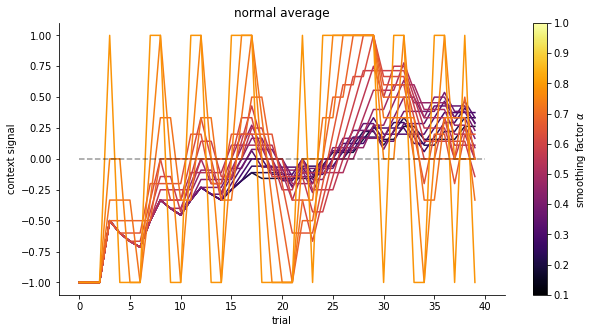

In [140]:
from matplotlib import cm ,colors
# normal average
n_windows = 20
plt.figure(figsize=(10,5))
cols = cm.inferno(np.linspace(0.1,0.8,n_windows))
windows = np.flip(np.arange(1,n_windows))

for window,col in zip(windows,cols):
    smth = []
    smth = pd.Series(data_int).rolling(window=window,min_periods=1).mean()    
    
    plt.plot(np.arange(len(smth)),smth,color=col,linestyle='-')
plt.plot([0,len(data_int)],[0,0],'k--',alpha=0.4)
plt.title('normal average')
cmap = cm.inferno
norm = colors.Normalize(vmin=0.1, vmax=1)

plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
              label=r'smoothing factor $\alpha$')

plt.xlabel('trial')
plt.ylabel('context signal')
sns.despine()

## Example of EMA

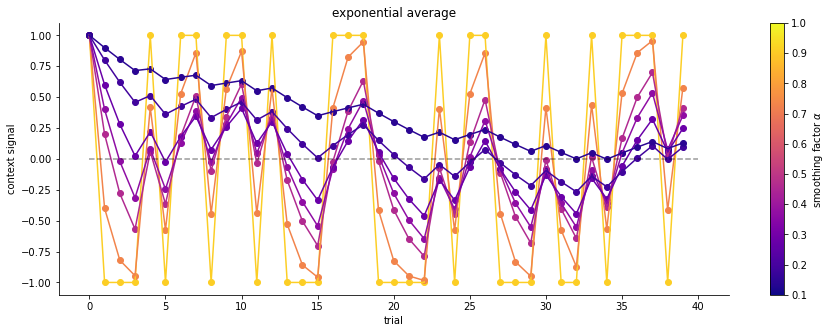

In [131]:
from matplotlib import cm ,colors
# exponential average
n_alphas = 20
plt.figure(figsize=(15,5))
cols = cm.plasma([0.05,0.1, 0.2, 0.3, 0.4, 0.7, 0.9])#cm.inferno(np.linspace(0.1,0.8,n_alphas))
alphas = [0.05,0.1, 0.2, 0.3, 0.4, 0.7, 1]#np.linspace(0.1,1,n_alphas)
data_int = np.random.randint(0,2,40)
data_int[data_int==0] = -1
# plt.scatter(np.arange(len(data_int)),data_int,color='k')
for alpha,col in zip(np.flip(alphas),np.flipud(cols)):
    smth = []
    # smth.append(data_int[0])
    # for i in data_int[1:]:
    #     smth.append(alpha*i+(1-alpha)*smth[-1])
    smth = pd.Series(data_int).ewm(alpha=alpha,adjust=False,min_periods=1).mean()    
    
    plt.plot(np.arange(len(smth)),smth,color=col,linestyle='-')
    plt.scatter(np.arange(len(smth)),smth, color=col)
plt.plot([0,len(data_int)],[0,0],'k--',alpha=0.4)
plt.title('exponential average')
cmap = cm.plasma
norm = colors.Normalize(vmin=0.1, vmax=1)

plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
              label=r'smoothing factor $\alpha$')

plt.xlabel('trial')
plt.ylabel('context signal')
sns.despine()

## Training Dynamics + Accuracy

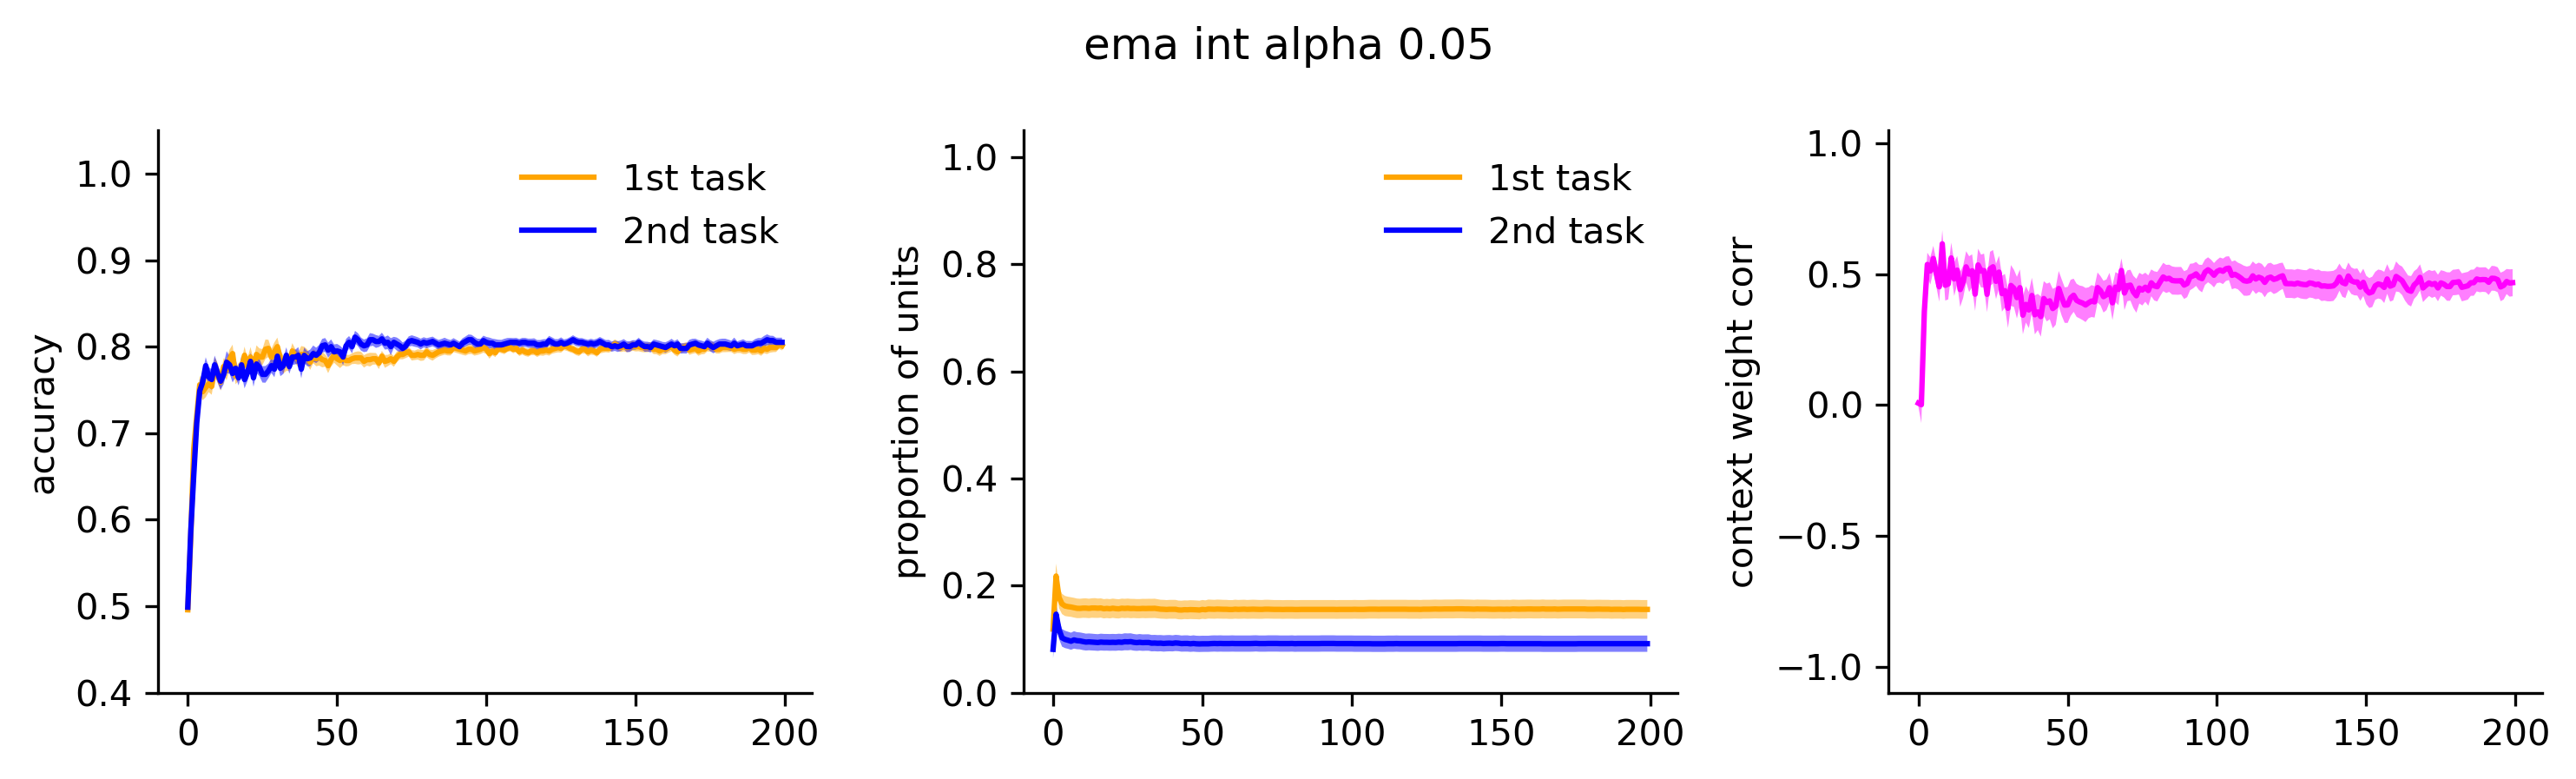

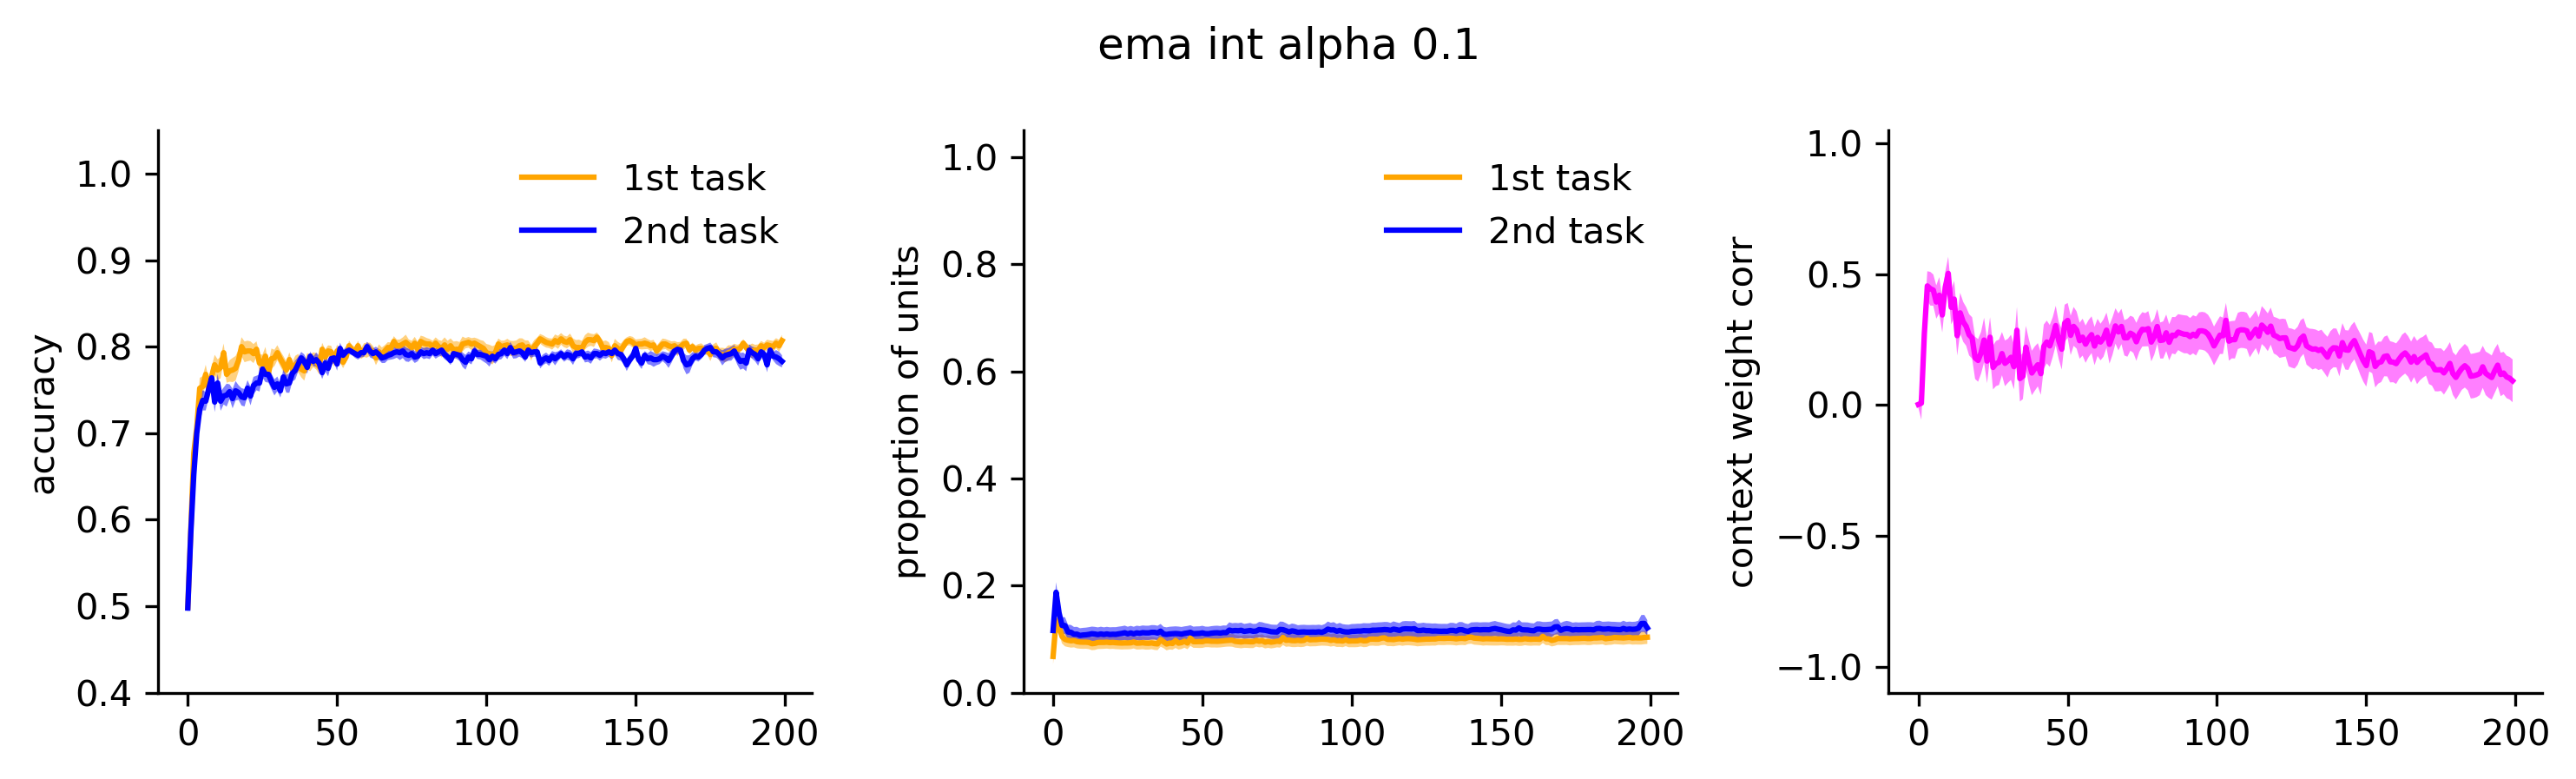

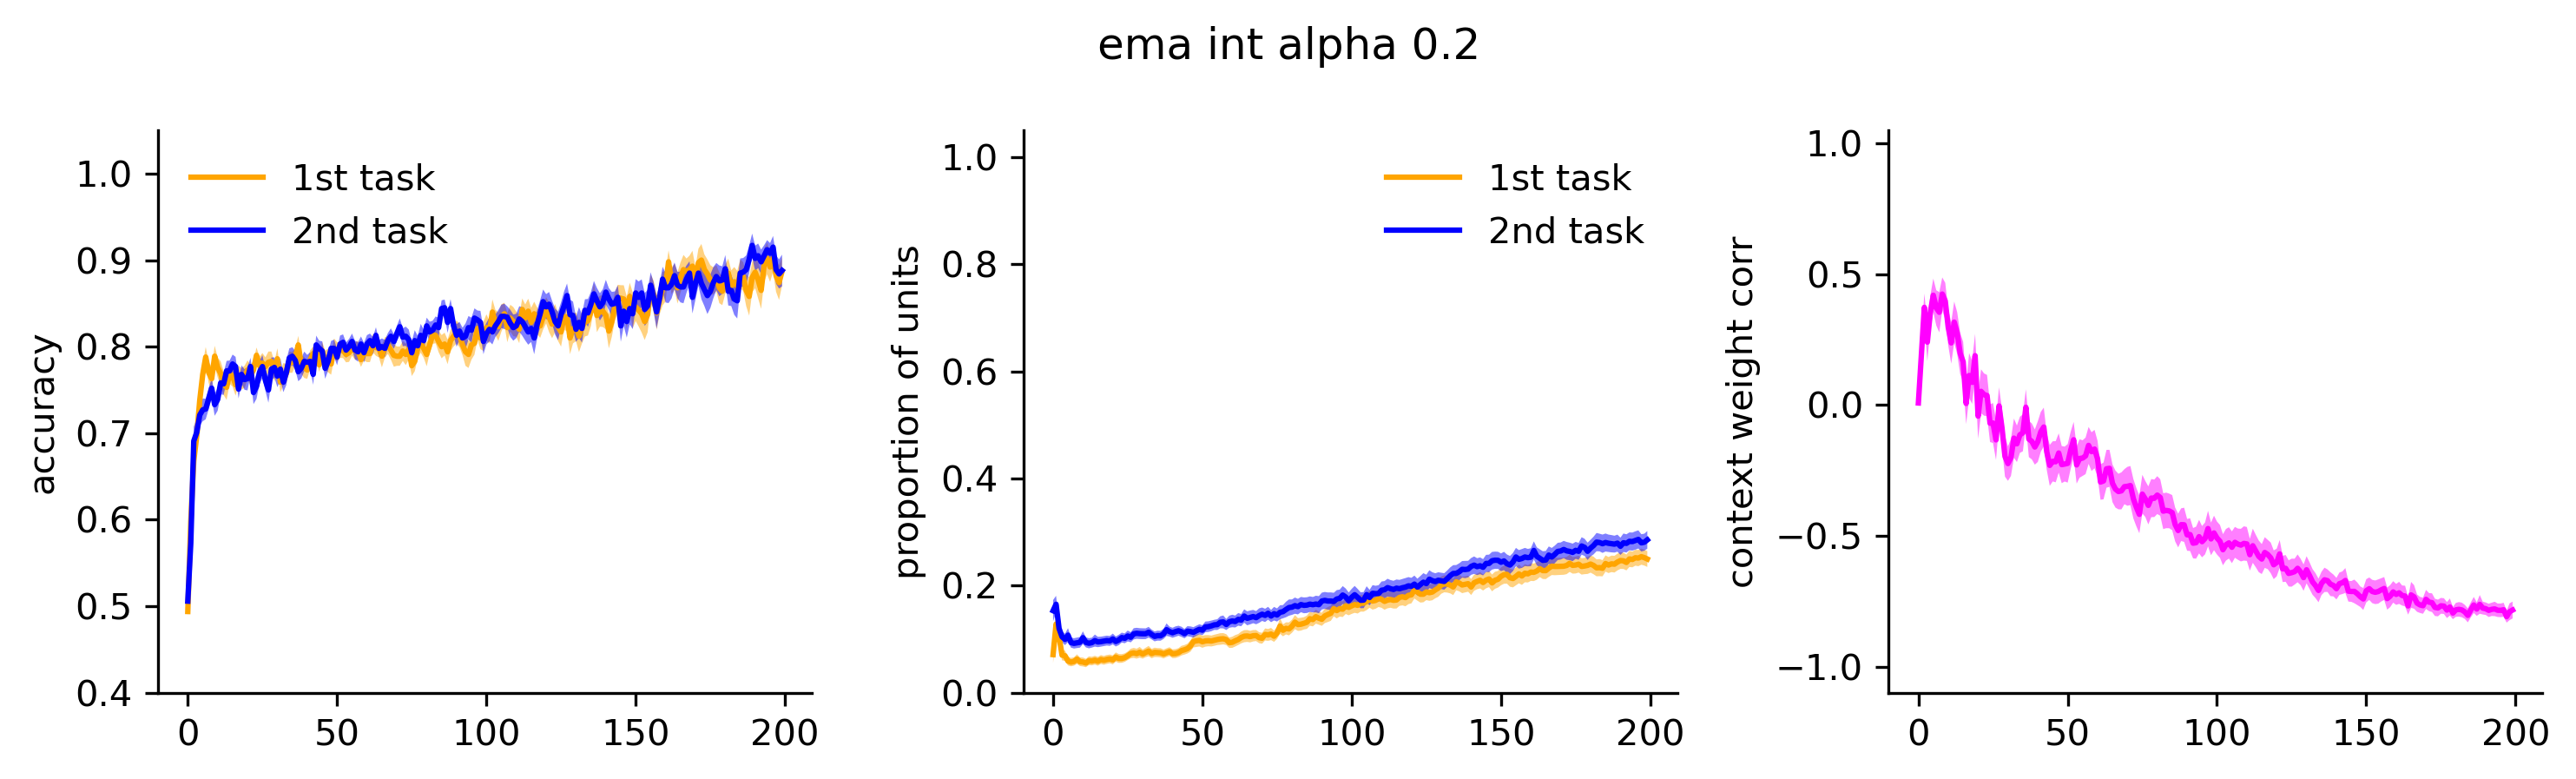

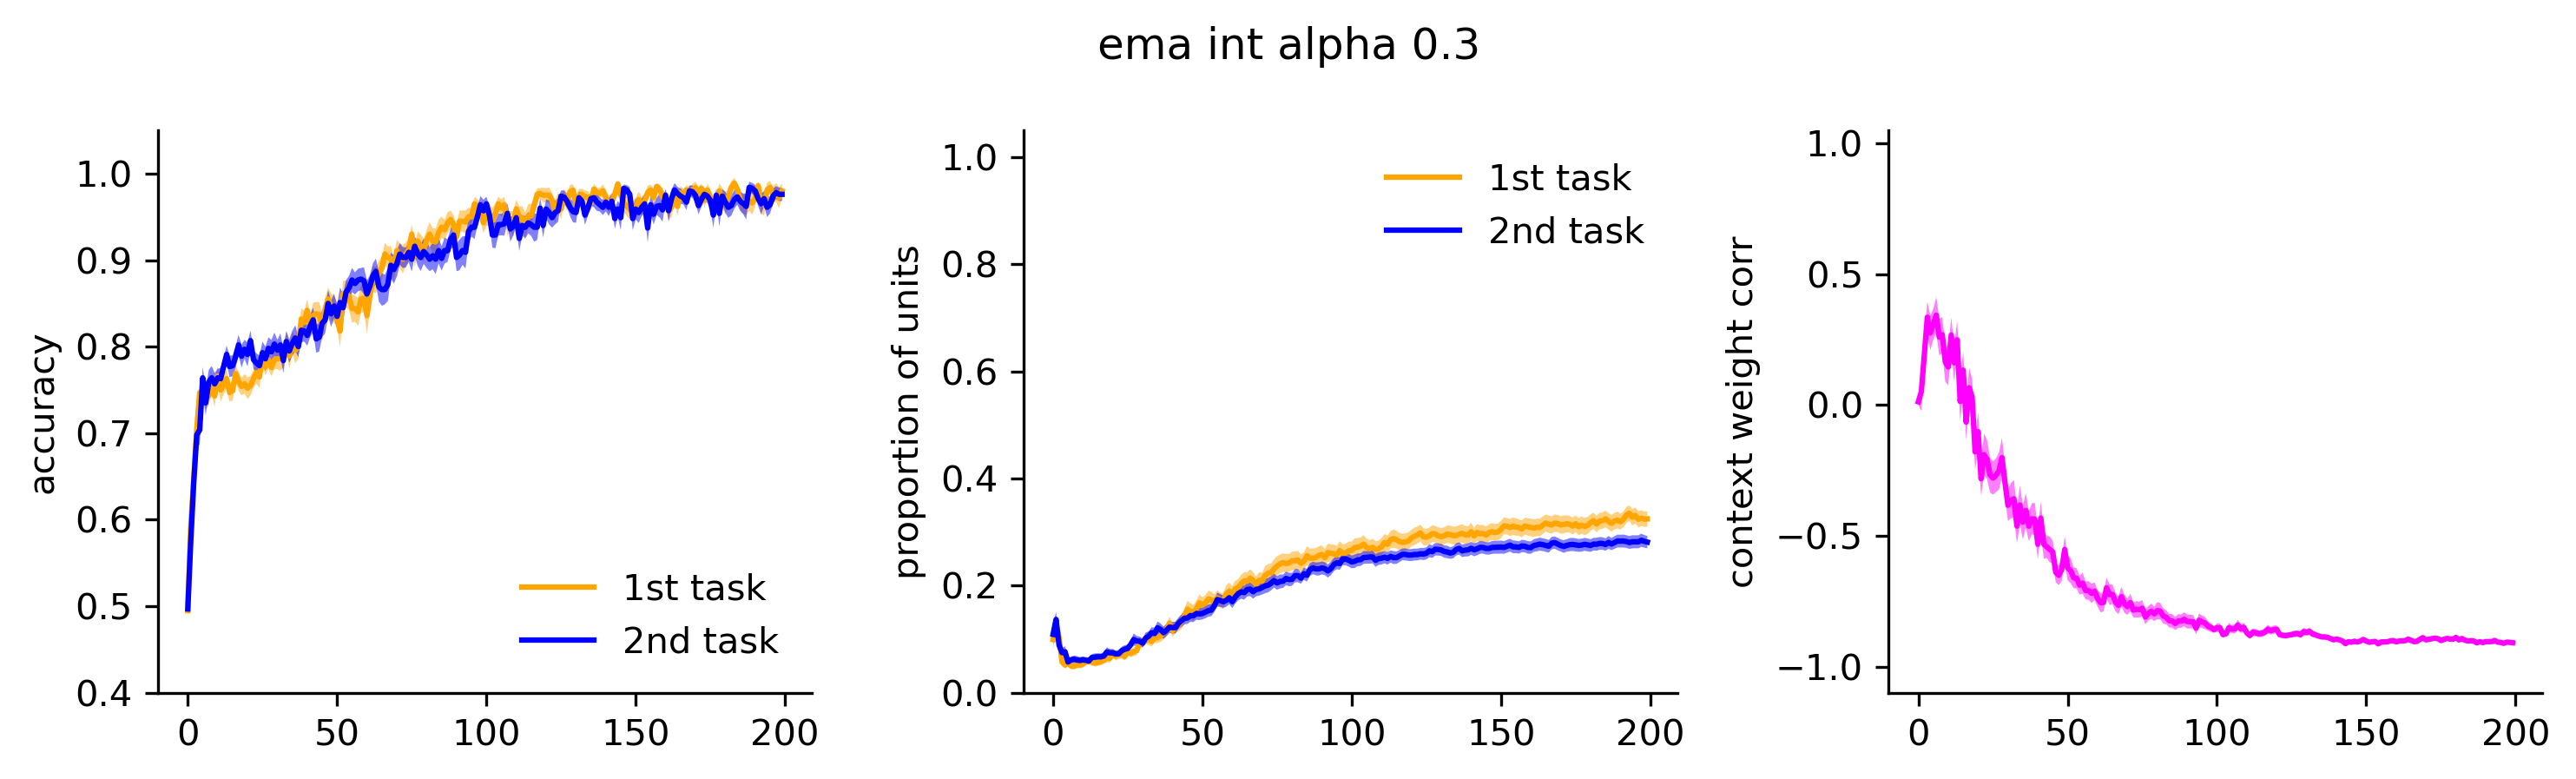

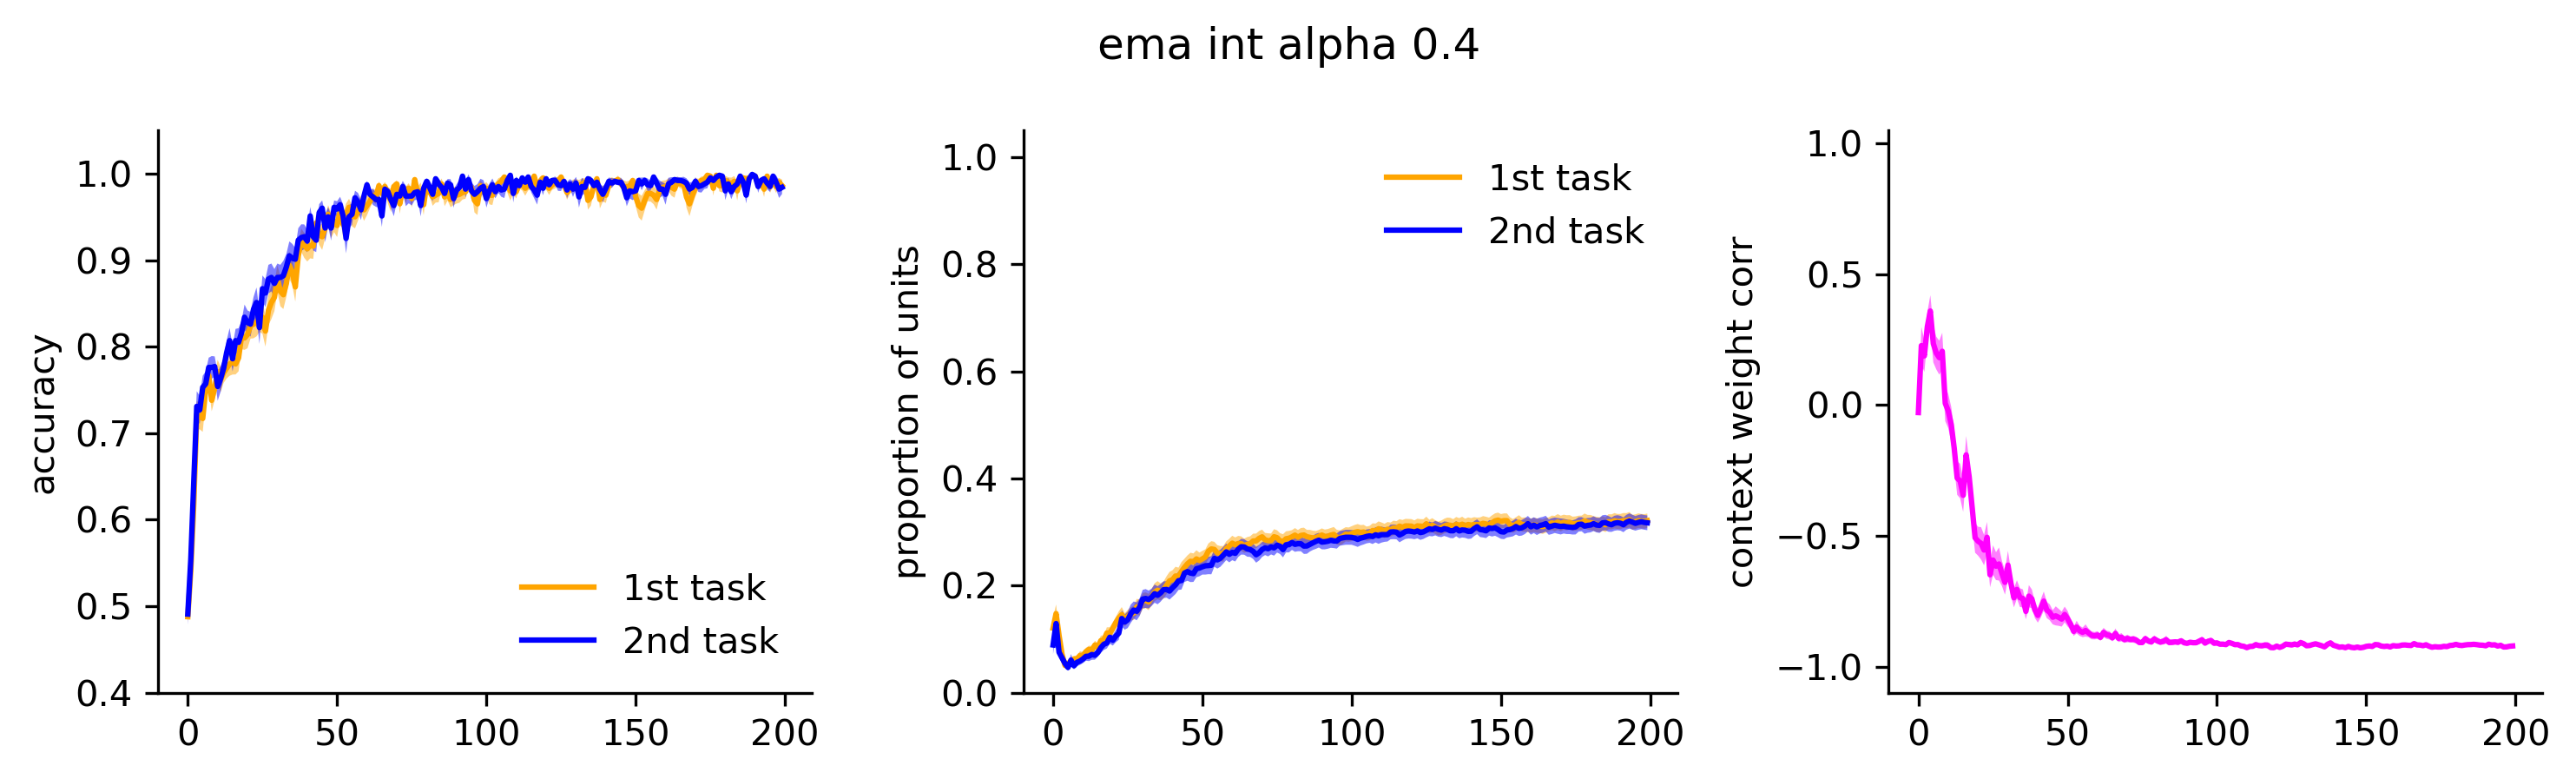

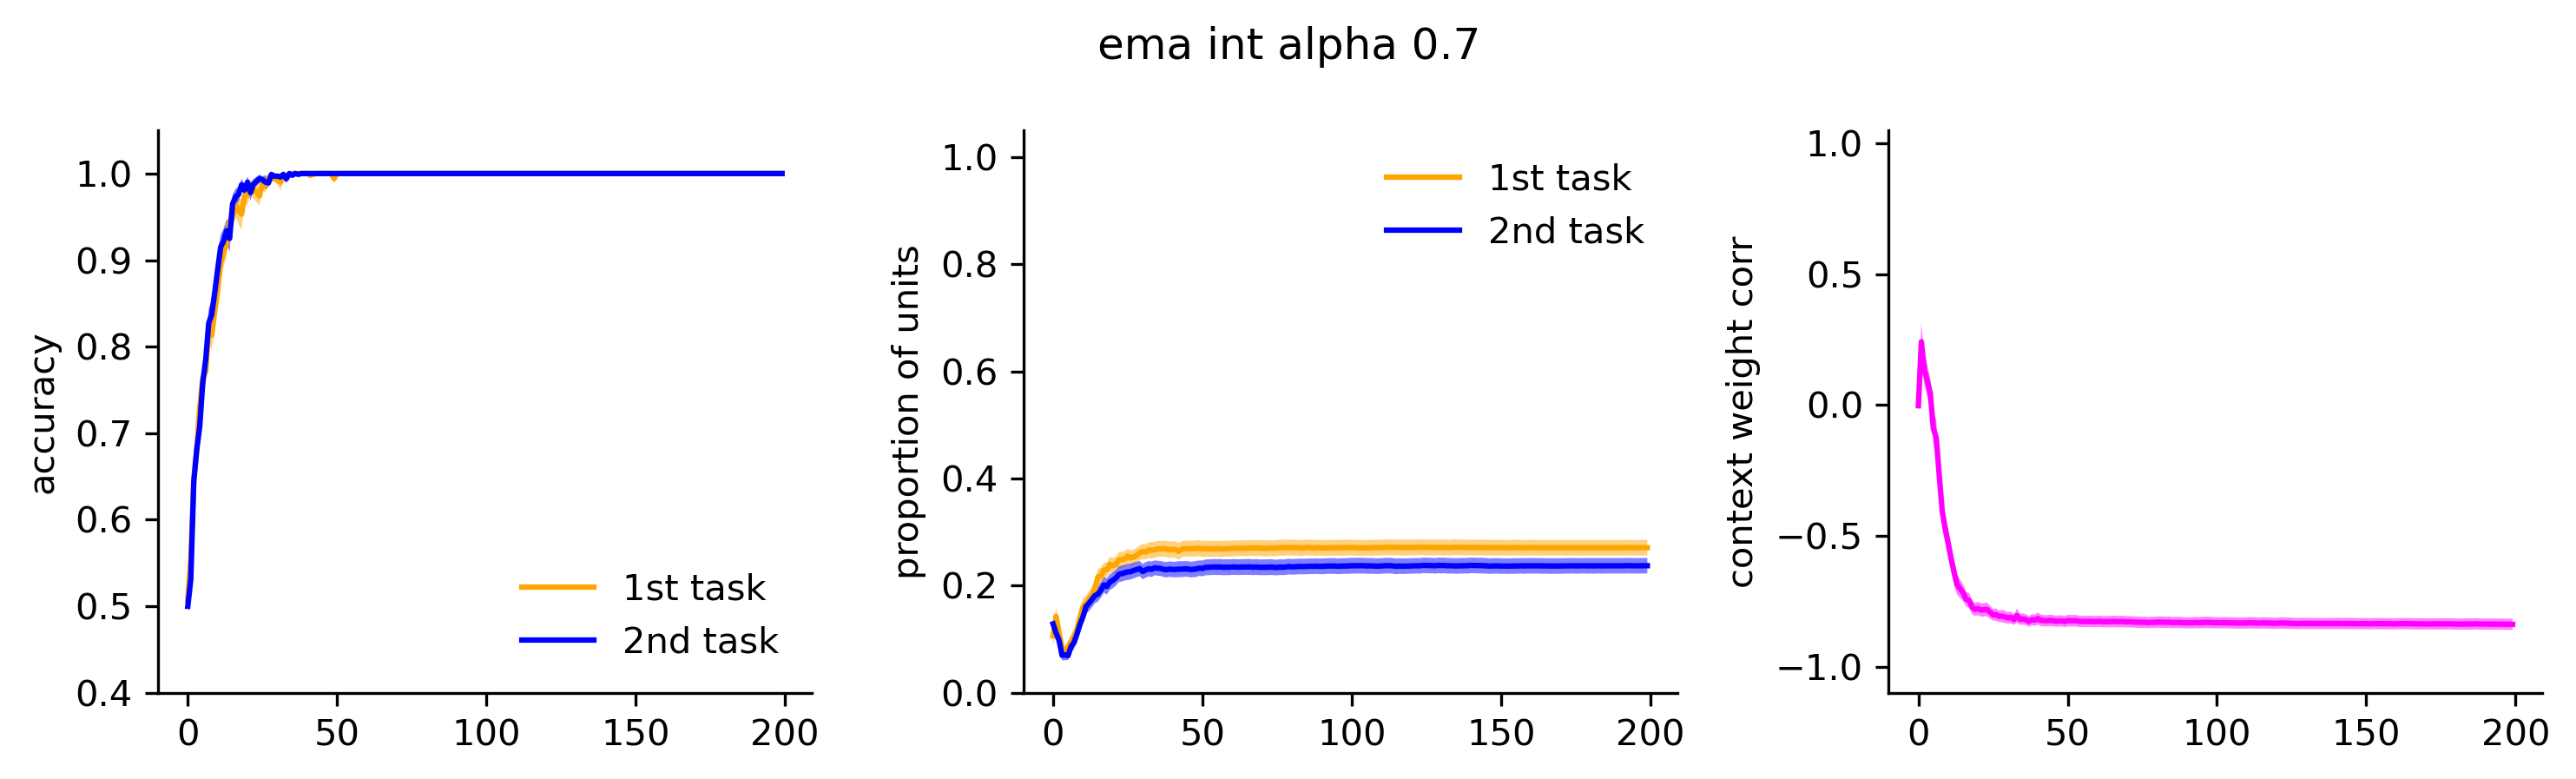

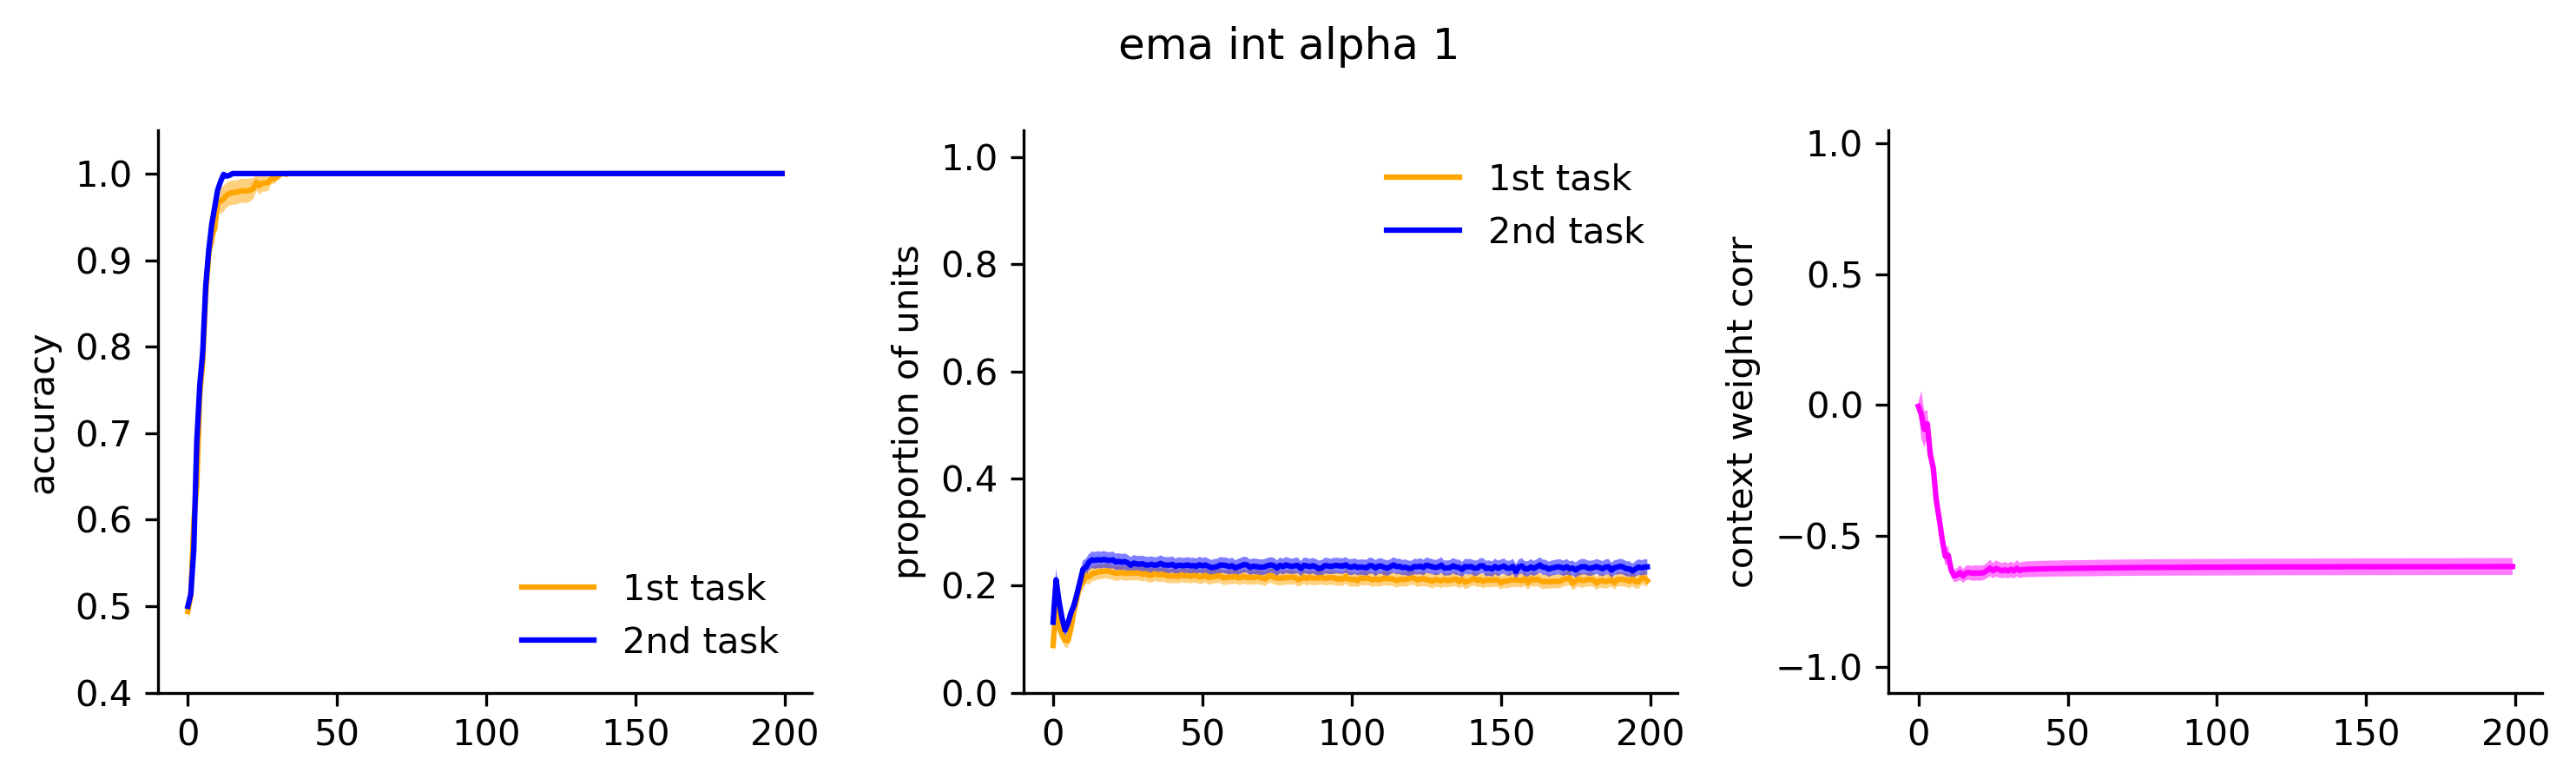

In [97]:
n_runs = 50
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alphas_to_plot = [0.05,0.1, 0.2, 0.3, 0.4, 0.7, 1]
idces = [np.where(alp==sluggish_vals)[0][0] for alp in alphas_to_plot]

for i,m in zip(idces,alphas_to_plot):
    f, axs = plt.subplots(1,3,figsize=(10,3),dpi=300)
    t_a = np.empty((n_runs,200))
    t_b = np.empty((n_runs,200))
    t_d = np.empty((n_runs,200))
    t_mixed = np.empty((n_runs,200))
    acc_1st = np.empty((n_runs,200))
    acc_2nd = np.empty((n_runs,200))
    contextcorr = np.empty((n_runs,200))

    for r in range(n_runs):
        with open('checkpoints/sluggish_baseline_int_sv'+ str(i) + '/run_' + str(r) +'/results.pkl','rb') as f:
            results = pickle.load(f)
            t_a[r,:] = results['n_only_a']/100
            t_b[r,:] = results['n_only_b']/100
            t_d[r,:] = results['n_dead']/100
            t_mixed[r,:] = 1-t_a[r,:]-t_b[r,:]-t_d[r,:]
            if m=='gated_blocked':
                contextcorr[r,:] = [-1]*200
            else:
                contextcorr[r,:] = results['w_context_corr']
            acc_1st[r,:] = results['acc_1st']
            acc_2nd[r,:] = results['acc_2nd']
    
    axs[0].plot(np.arange(200),acc_1st.mean(0),color='orange')
    axs[0].fill_between(np.arange(200),acc_1st.mean(0)-np.std(acc_1st,0)/np.sqrt(n_runs),acc_1st.mean(0)+np.std(acc_1st,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
    axs[0].plot(np.arange(200),acc_2nd.mean(0),color='blue')
    axs[0].fill_between(np.arange(200),acc_2nd.mean(0)-np.std(acc_2nd,0)/np.sqrt(n_runs),acc_2nd.mean(0)+np.std(acc_2nd,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)
    axs[0].set_ylim([0.4,1.05])
    axs[0].set(ylabel='accuracy')
    axs[0].legend(['1st task','2nd task'],frameon=False)
    # axs[0].plot([100,100],[0,1],'k--',alpha=0.5)
    plt.suptitle('ema int alpha '+str(np.round(m,2)))
    sns.despine()


    axs[1].plot(np.arange(200),t_b.mean(0),color='orange')
    axs[1].fill_between(np.arange(200),t_b.mean(0)-np.std(t_b,0)/np.sqrt(n_runs),t_b.mean(0)+np.std(t_b,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
    axs[1].plot(np.arange(200),t_a.mean(0),color='blue')
    axs[1].fill_between(np.arange(200),t_a.mean(0)-np.std(t_a,0)/np.sqrt(n_runs),t_a.mean(0)+np.std(t_a,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)
    # axs[1].plot(np.arange(200),t_mixed.mean(0),color='darkgreen',linestyle='--')
    # axs[1].plot(np.arange(200),t_d.mean(0),color='red',linestyle='--')
    plt.suptitle('ema int alpha '+str(np.round(m,2)))
    axs[1].set_ylim([0,1.05])
    axs[1].set(ylabel='proportion of units')
    axs[1].legend(['1st task','2nd task'],frameon=False)
    # axs[1].plot([100,100],[0,1],'k--',alpha=0.5)
    sns.despine()

    axs[2].plot(np.arange(200),contextcorr.mean(0),color='magenta')    
    axs[2].fill_between(np.arange(200),contextcorr.mean(0)-np.std(contextcorr,0)/np.sqrt(n_runs),contextcorr.mean(0)+np.std(contextcorr,0)/np.sqrt(n_runs),alpha=0.5,color='magenta',edgecolor=None)
    plt.suptitle('ema int alpha '+str(np.round(m,2)))
    axs[2].set_ylim([-1.1,1.05])
    axs[2].set(ylabel='context weight corr')    
    # axs[2].plot([100,100],[-1,1],'k--',alpha=0.5)
    sns.despine()
    plt.tight_layout()


## Accuracy

(0.4, 1.0)

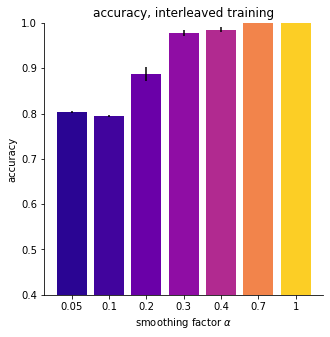

In [148]:
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alphas_to_plot = [0.05,0.1, 0.2, 0.3, 0.4, 0.7, 1]
idces = [np.where(alp==sluggish_vals)[0][0] for alp in alphas_to_plot]
cols = cm.plasma([0.05,0.1, 0.2, 0.3, 0.4, 0.7, 0.9])


n_runs = 50 
f,axs = plt.subplots(1,1,figsize=(5,5))


for pli,ii,sv,col in zip(np.arange(len(idces)),idces,alphas_to_plot,cols):
    acc_a = []
    acc_b = []
    for r in np.arange(0,n_runs):
        with open('checkpoints/sluggish_baseline_int_sv'+ str(ii) + '/run_' + str(r) +'/results.pkl','rb') as f:
            results = pickle.load(f)
            acc_a.append(results['acc_1st'][-1])
            acc_b.append(results['acc_2nd'][-1])
    acc = (np.array(acc_a)+np.array(acc_b))/2
    plt.bar(pli,acc.mean(),yerr=np.std(acc)/np.sqrt(n_runs),color=col)    
    sns.despine()

plt.xlabel(r'smoothing factor $\alpha$')
plt.title('accuracy, interleaved training')
plt.xticks(ticks=np.arange(7),labels=alphas_to_plot)
plt.ylabel('accuracy')
plt.ylim(0.4,1)
    

## Sigmoids

Text(0, 0.5, 'p(accept)')

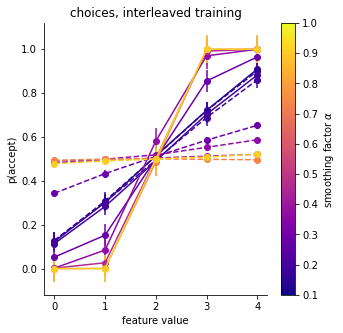

In [129]:
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alphas_to_plot = [0.05,0.1, 0.2, 0.3, 0.4, 0.7, 1]
idces = [np.where(alp==sluggish_vals)[0][0] for alp in alphas_to_plot]
cols = cm.plasma([0.05,0.1, 0.2, 0.3, 0.4, 0.7, 0.9])


n_runs = 50 
f,axs = plt.subplots(1,1,figsize=(5,5))


for ii,sv,col in zip(idces,alphas_to_plot,cols):
    cmats_a = []
    cmats_b = []
    corrs_run_b = []
    corrs_run_i = []
    for r in np.arange(0,n_runs):
        with open('checkpoints/sluggish_baseline_int_sv'+ str(ii) + '/run_' + str(r) +'/results.pkl','rb') as f:
            results = pickle.load(f)
            cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
            choices = 1/(1+np.exp(-cc))
            cmats_a.append(choices[:25].reshape(5,5))
            cmats_b.append(choices[25:].reshape(5,5))
            
    cmats_a = np.array(cmats_a)
    cmats_b = np.array(cmats_b)
    choices_rel = (cmats_a.mean(2) + cmats_b.mean(1))/2
    choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2))/2
    plt.errorbar(np.arange(5),choices_rel.mean(0),yerr=np.std(choices_rel.mean(0))/np.sqrt(n_runs),marker='o',color=col)
    plt.errorbar(np.arange(5),choices_irrel.mean(0),yerr=np.std(choices_irrel.mean(0))/np.sqrt(n_runs),marker='o',color=col,linestyle='--')
    sns.despine()
cmap = cm.plasma
norm = colors.Normalize(vmin=0.1, vmax=1)

plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
              label=r'smoothing factor $\alpha$')
plt.title('choices, interleaved training')
plt.xlabel('feature value')
plt.ylabel('p(accept)')
    

## Choice Matrices

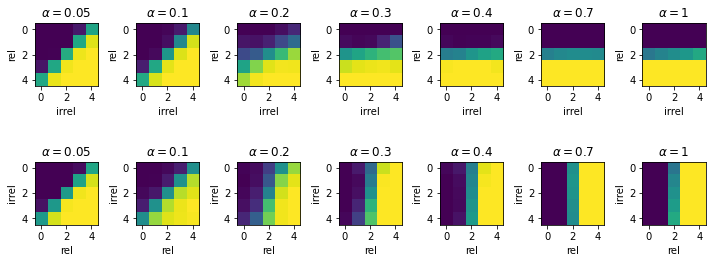

In [137]:
# load data with different sluggishness levels 
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alphas_to_plot = [0.05,0.1, 0.2, 0.3, 0.4, 0.7, 1]
idces = [np.where(alp==sluggish_vals)[0][0] for alp in alphas_to_plot]


n_runs = 50 
f,axs = plt.subplots(2,7,figsize=(10,4))


for ax1,ax2,ii,sv in zip(axs[0,:],axs[1,:],idces,alphas_to_plot):
    cmats_a = []
    cmats_b = []
    corrs_run_b = []
    corrs_run_i = []
    for r in np.arange(0,n_runs):
        with open('checkpoints/sluggish_baseline_int_sv'+ str(ii) + '/run_' + str(r) +'/results.pkl','rb') as f:
            results = pickle.load(f)
            cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
            choices = 1/(1+np.exp(-cc))
            cmats_a.append(choices[:25].reshape(5,5))
            cmats_b.append(choices[25:].reshape(5,5))
            
    cmats_a = np.array(cmats_a)
    cmats_b = np.array(cmats_b)
    ax1.imshow(cmats_a.mean(0))
    ax1.set_title(r'$\alpha=$%s'%np.round(sv,2))
    ax1.set(xticks=[0,2,4],yticks=[0,2,4],xlabel='irrel',ylabel='rel')
    ax2.imshow(cmats_b.mean(0))
    ax2.set(xticks=[0,2,4],yticks=[0,2,4],xlabel='rel',ylabel='irrel')
    ax2.set_title(r'$\alpha=$%s'%np.round(sv,2))
plt.tight_layout()



# SLA + interleaved

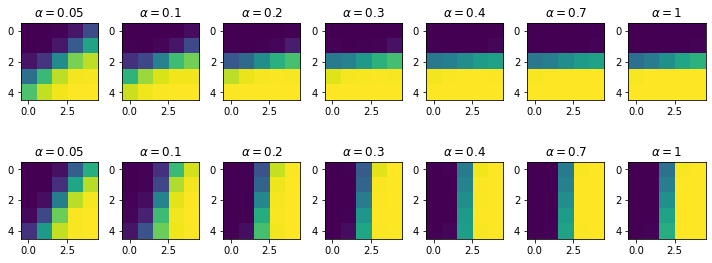

In [104]:
# load data with different sluggishness levels 
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alphas_to_plot = [0.05,0.1, 0.2, 0.3, 0.4, 0.7, 1]
idces = [np.where(alp==sluggish_vals)[0][0] for alp in alphas_to_plot]


n_runs = 50 
f,axs = plt.subplots(2,7,figsize=(10,4))


for ax1,ax2,ii,sv in zip(axs[0,:],axs[1,:],idces,alphas_to_plot):
    cmats_a = []
    cmats_b = []
    corrs_run_b = []
    corrs_run_i = []
    for r in np.arange(0,n_runs):
        with open('checkpoints/sluggish_sla_int_sv'+ str(ii) + '/run_' + str(r) +'/results.pkl','rb') as f:
            results = pickle.load(f)
            cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
            choices = 1/(1+np.exp(-cc))
            cmats_a.append(choices[:25].reshape(5,5))
            cmats_b.append(choices[25:].reshape(5,5))
            
    cmats_a = np.array(cmats_a)
    cmats_b = np.array(cmats_b)
    ax1.imshow(cmats_a.mean(0))
    ax1.set_title(r'$\alpha=$%s'%np.round(sv,2))
    ax2.imshow(cmats_b.mean(0))
    ax2.set_title(r'$\alpha=$%s'%np.round(sv,2))
plt.tight_layout()



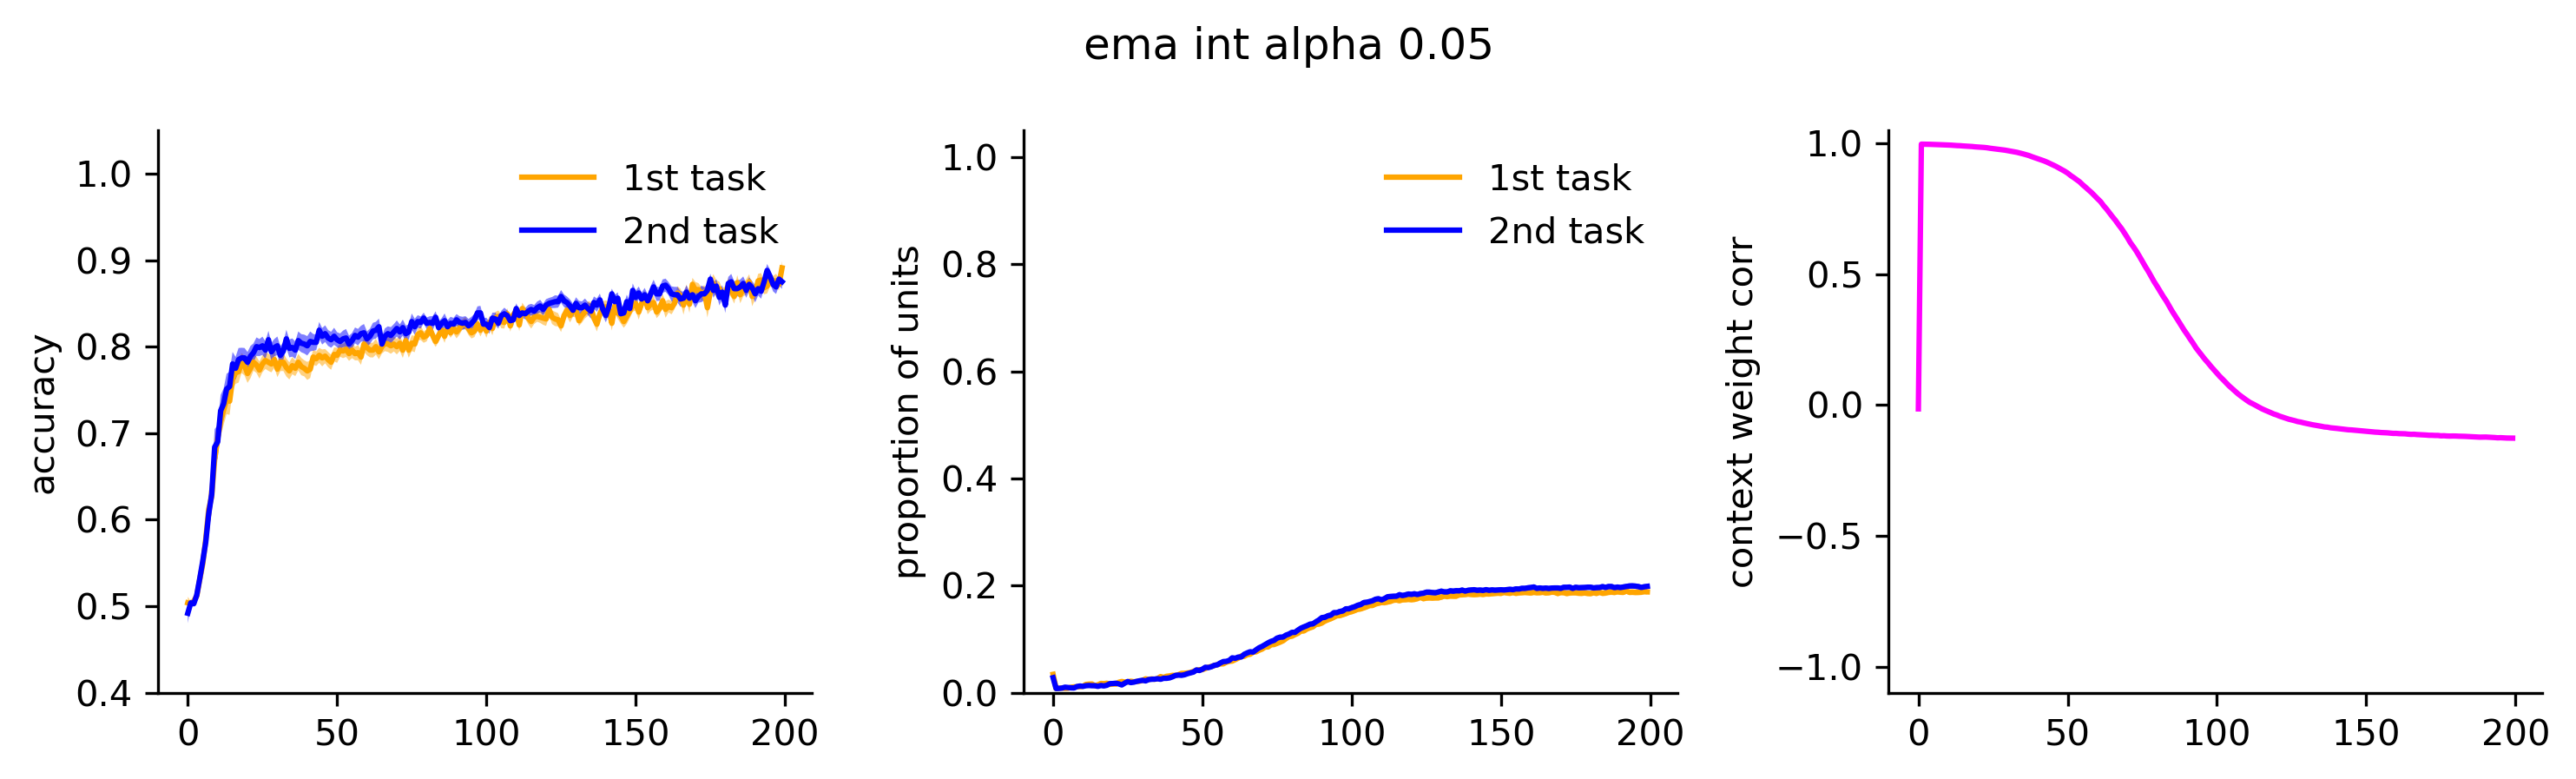

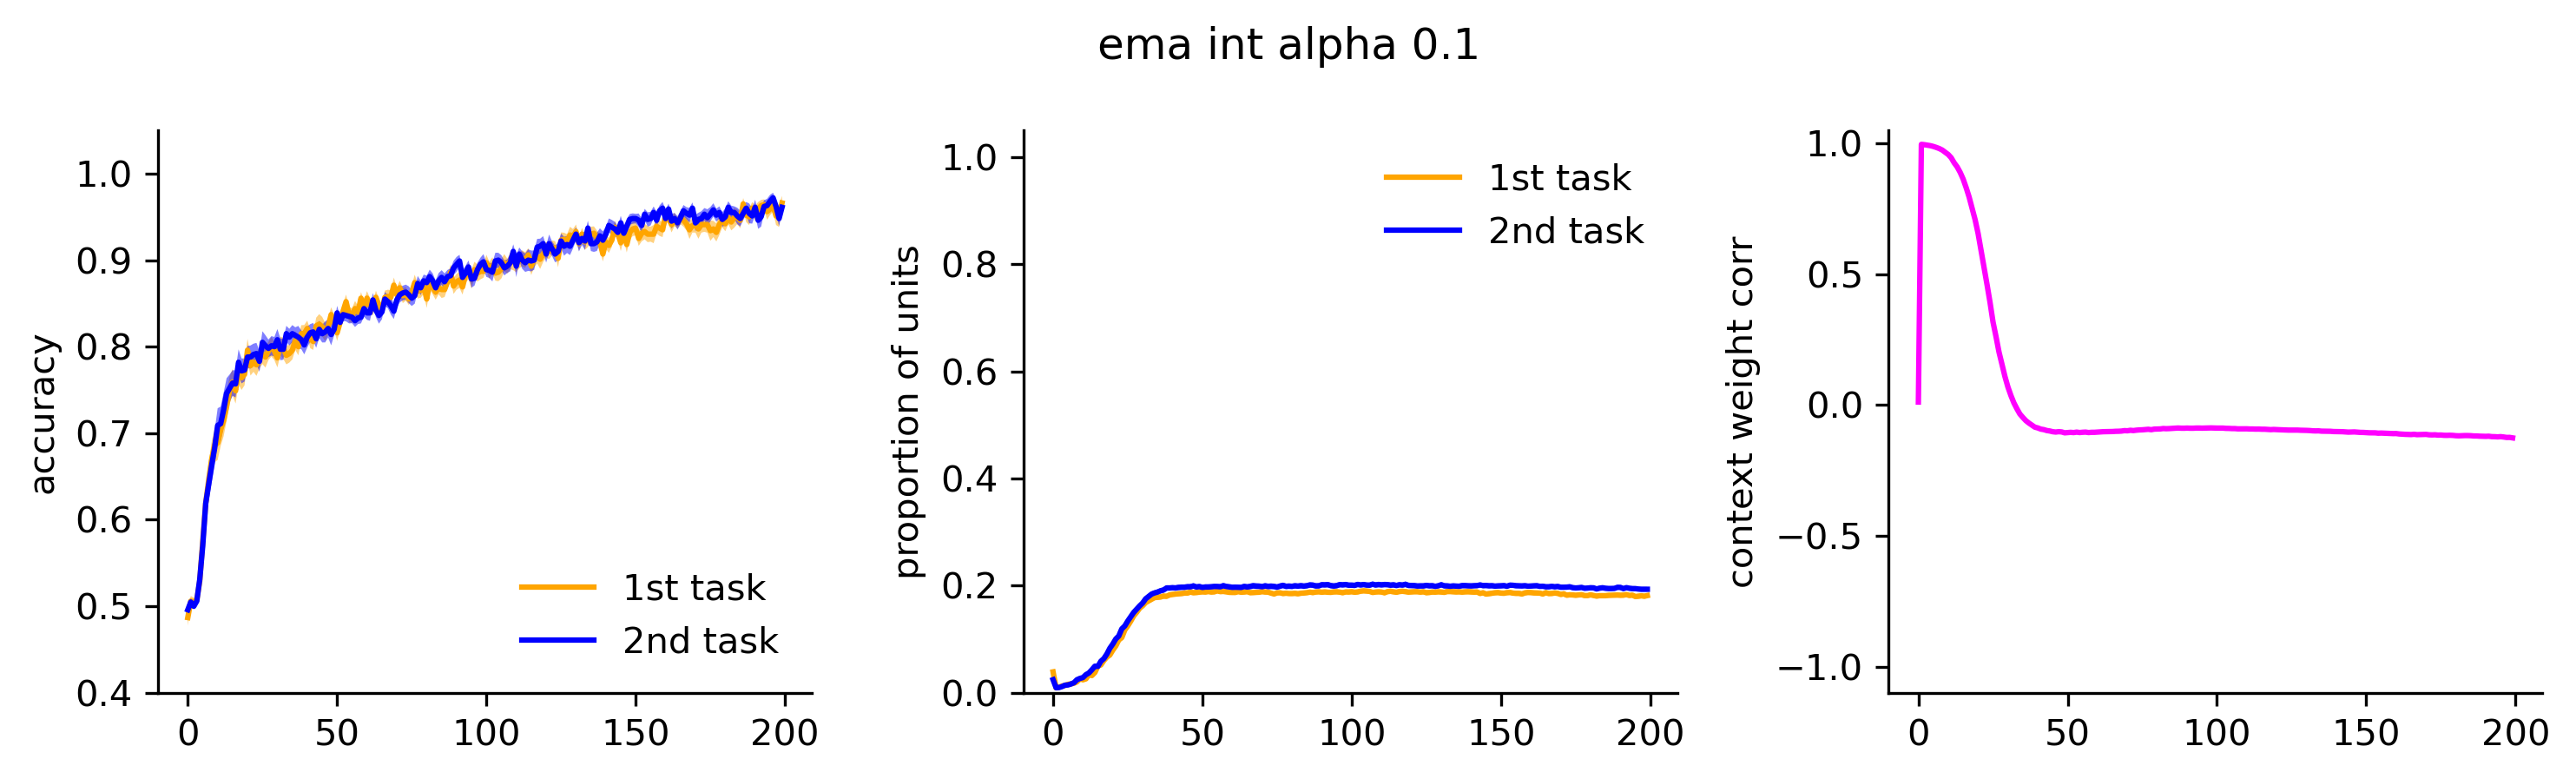

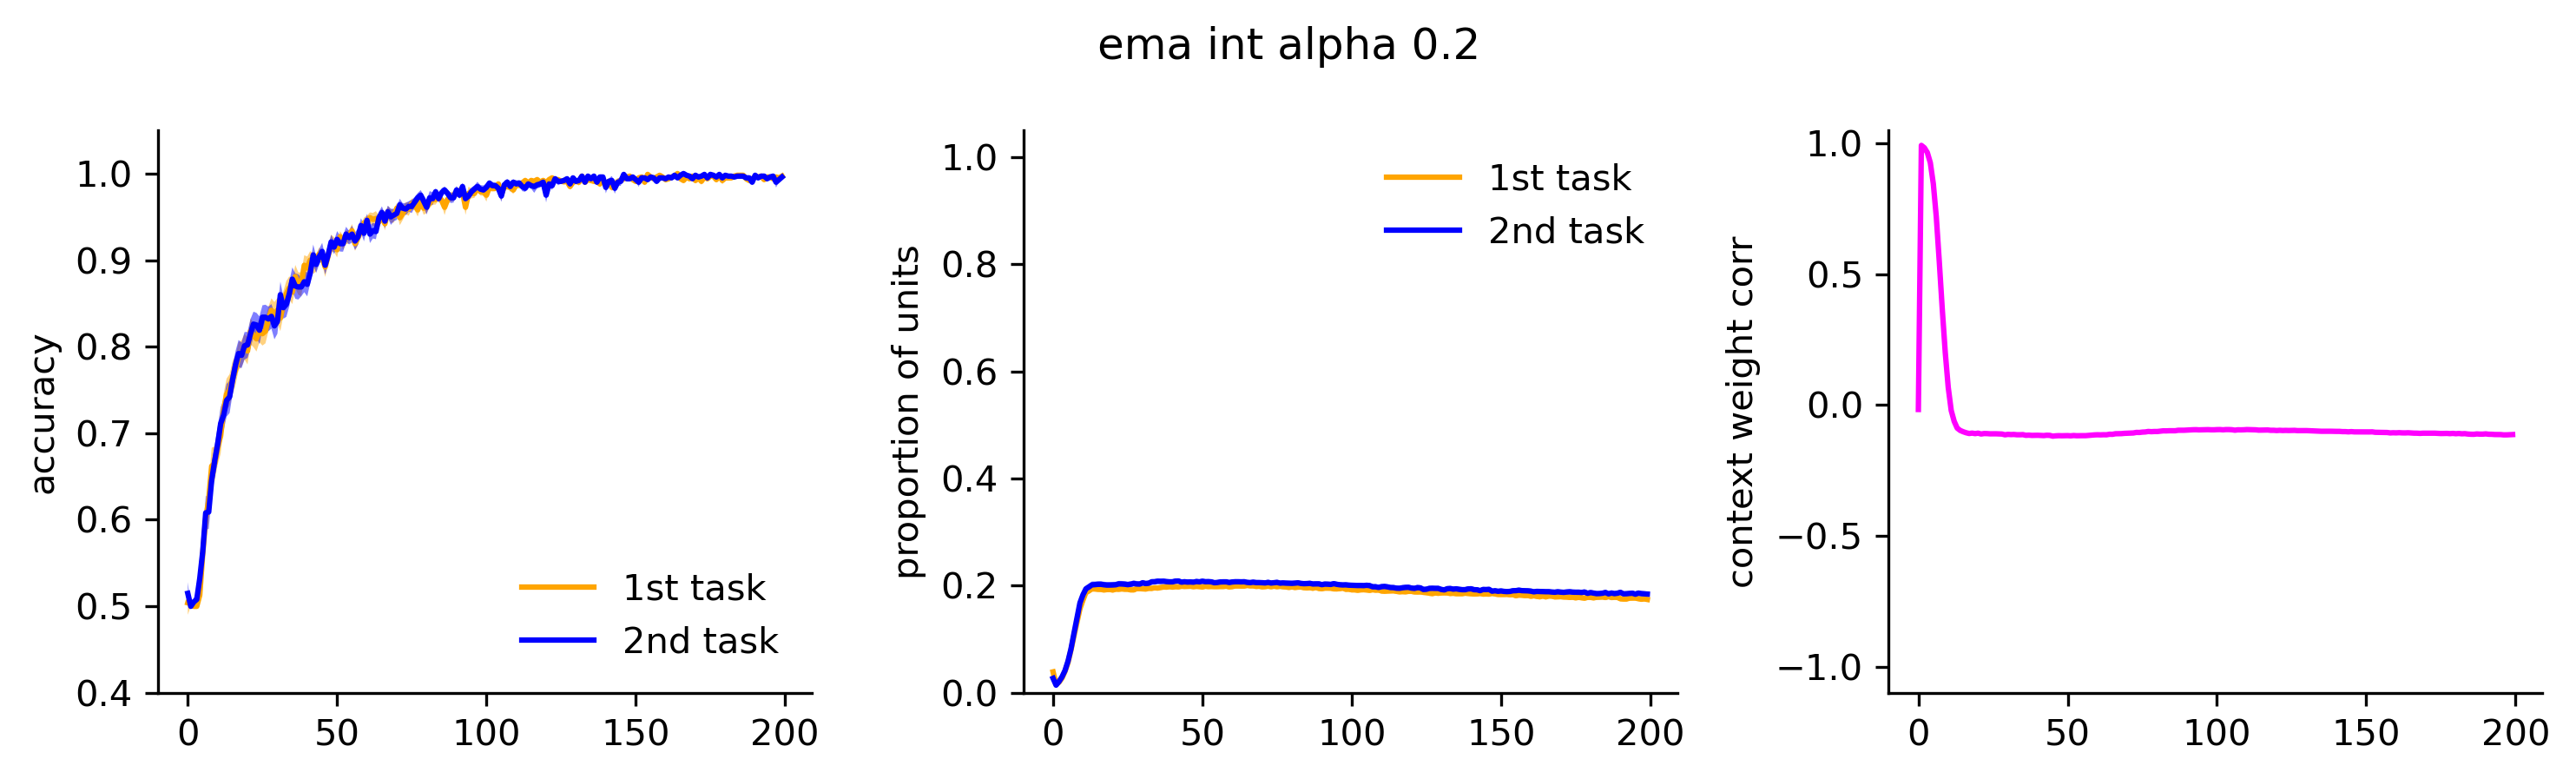

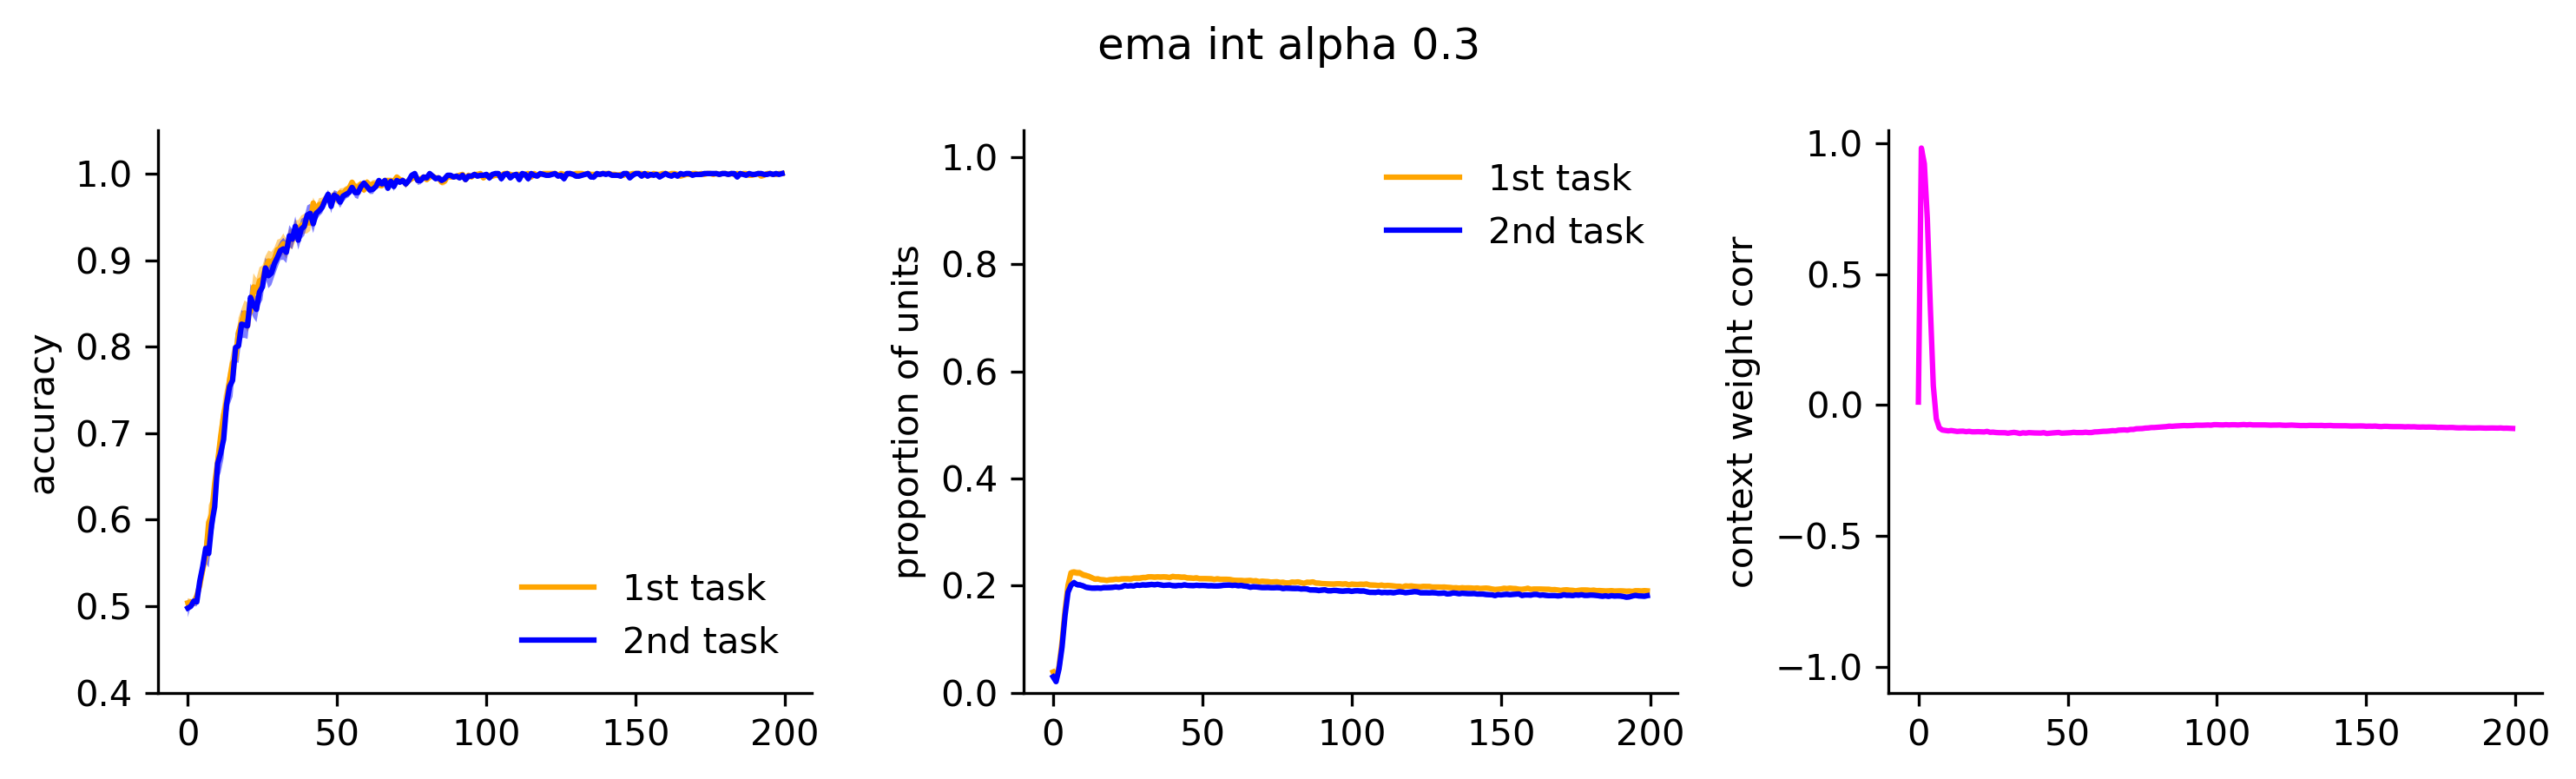

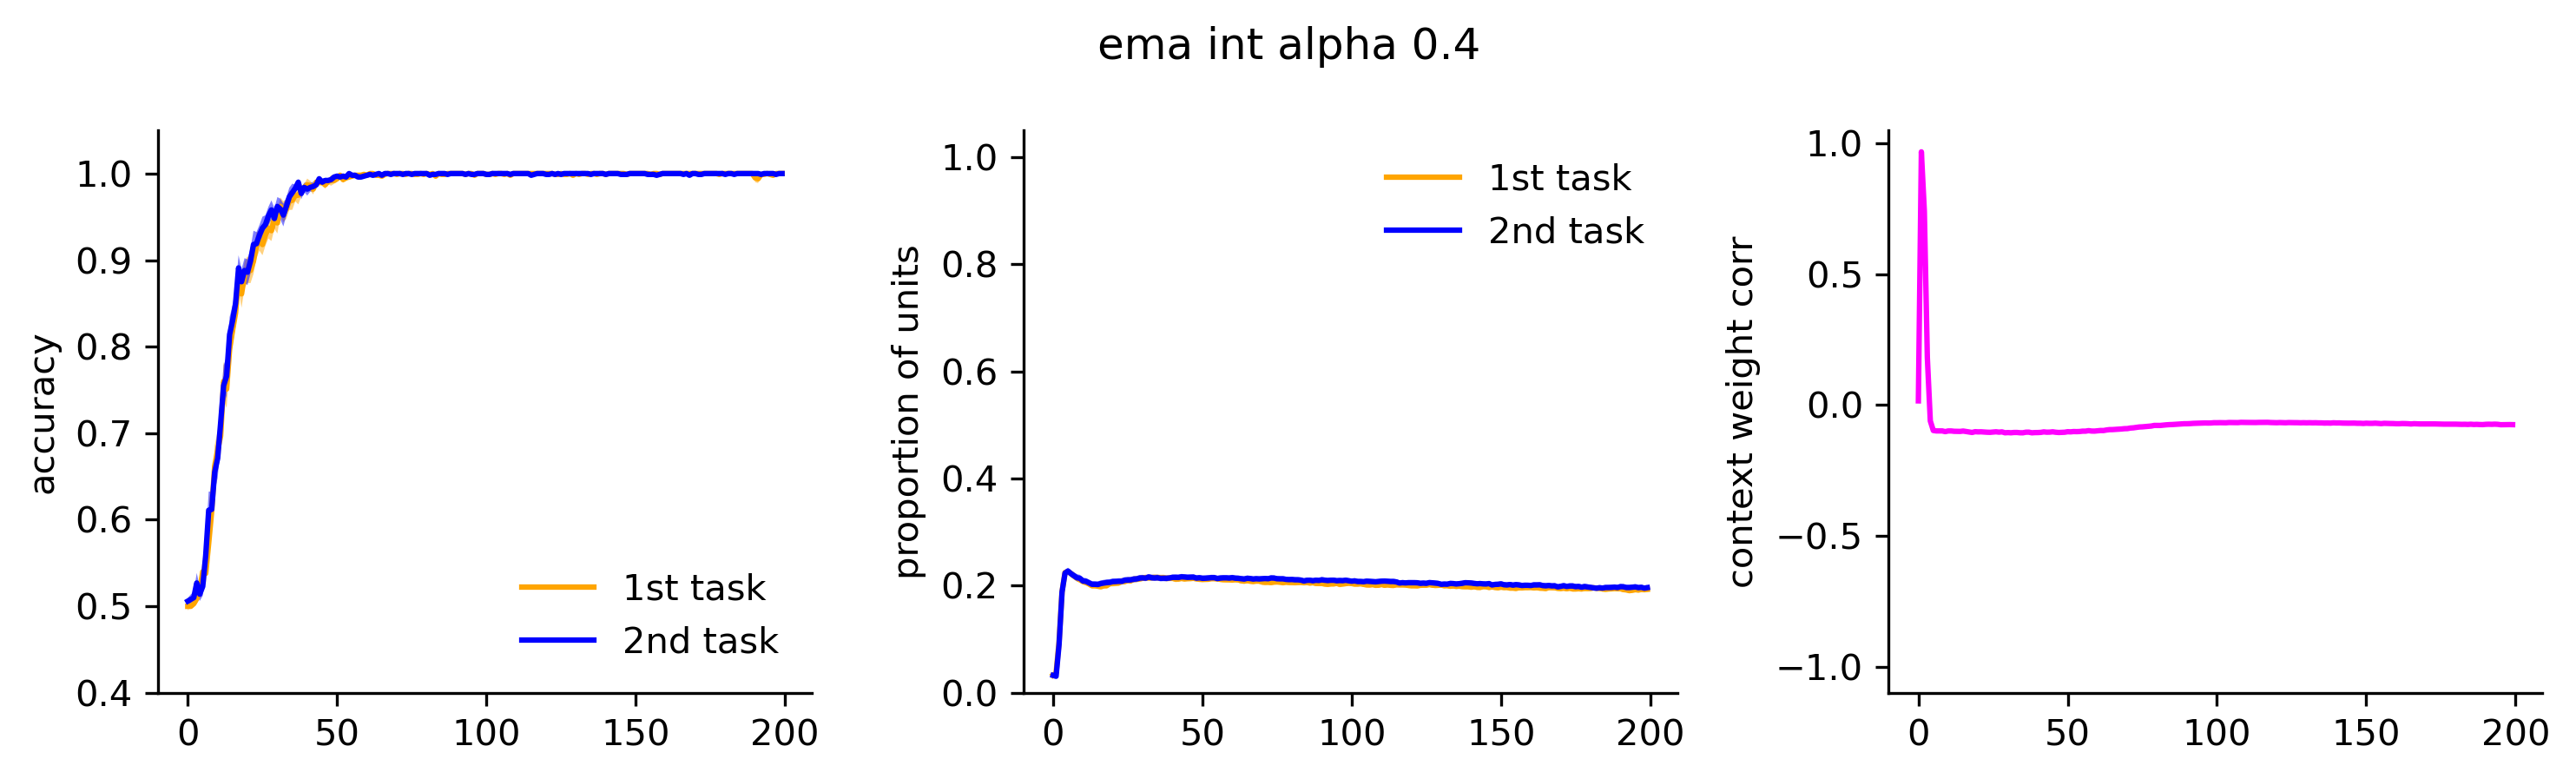

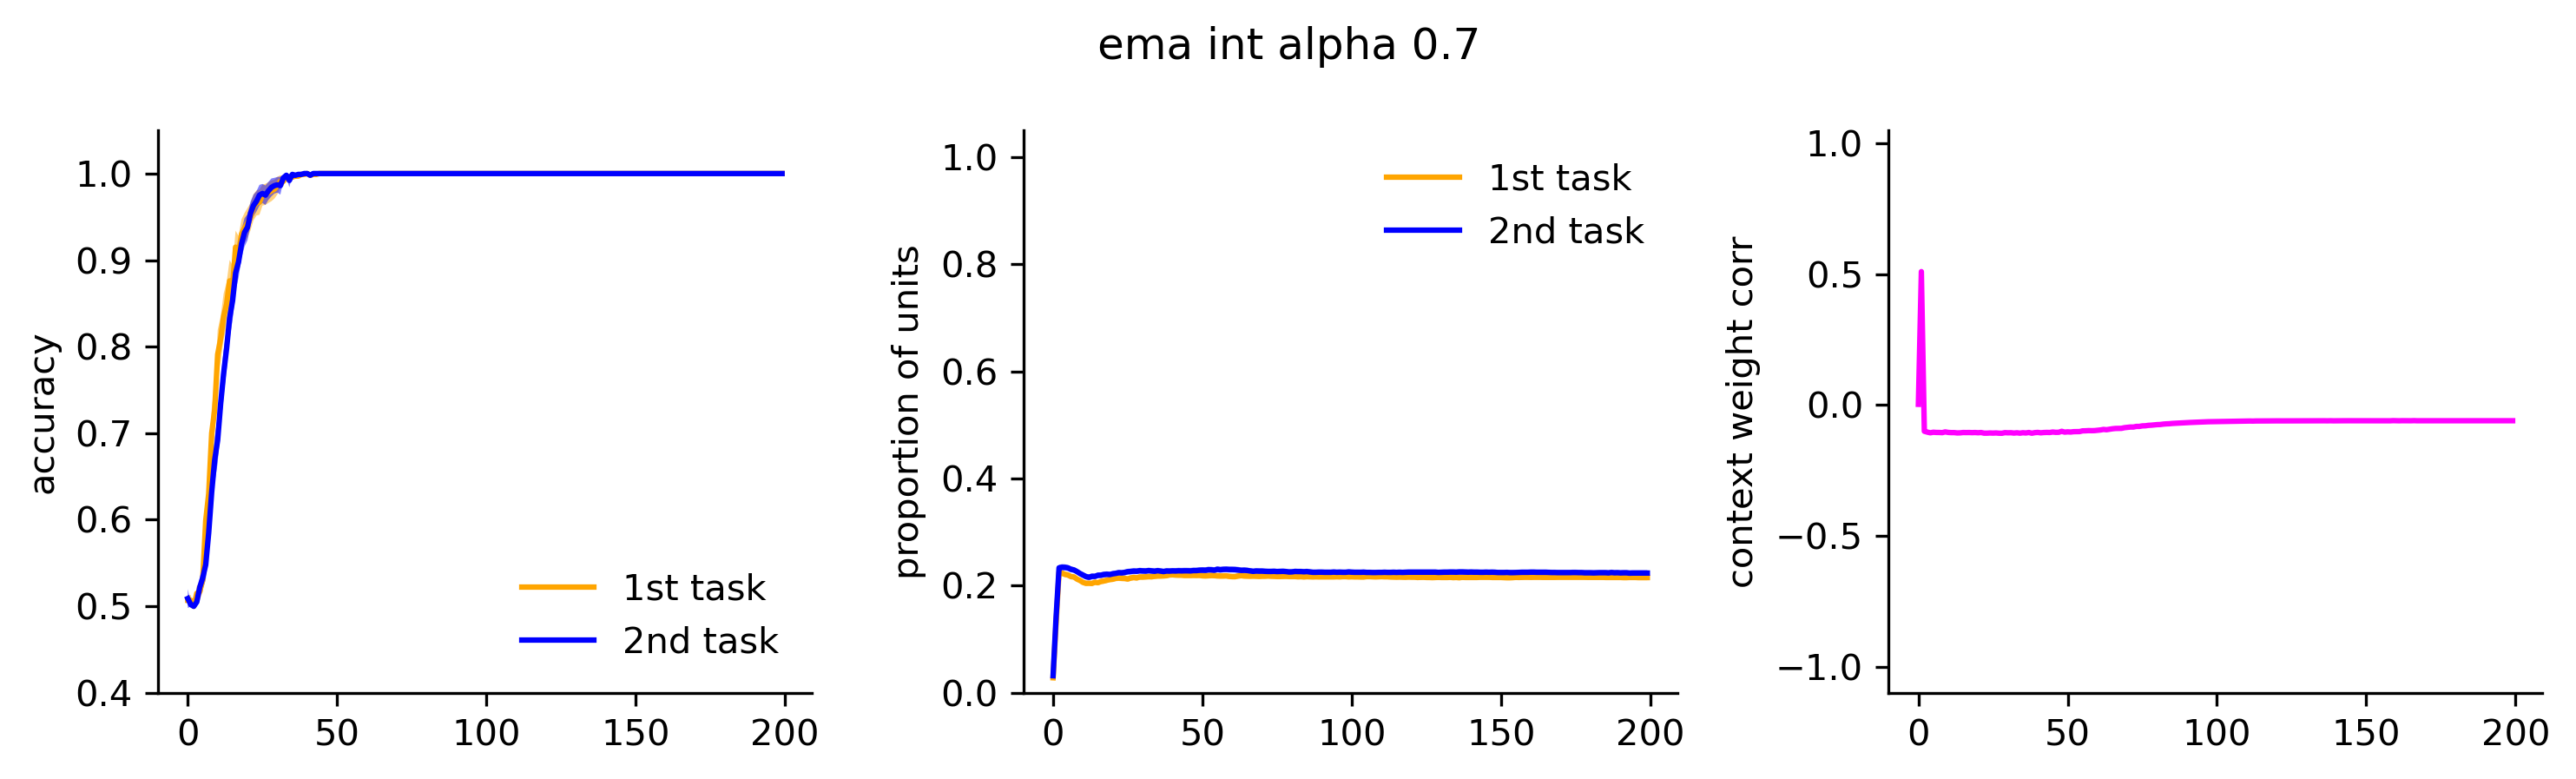

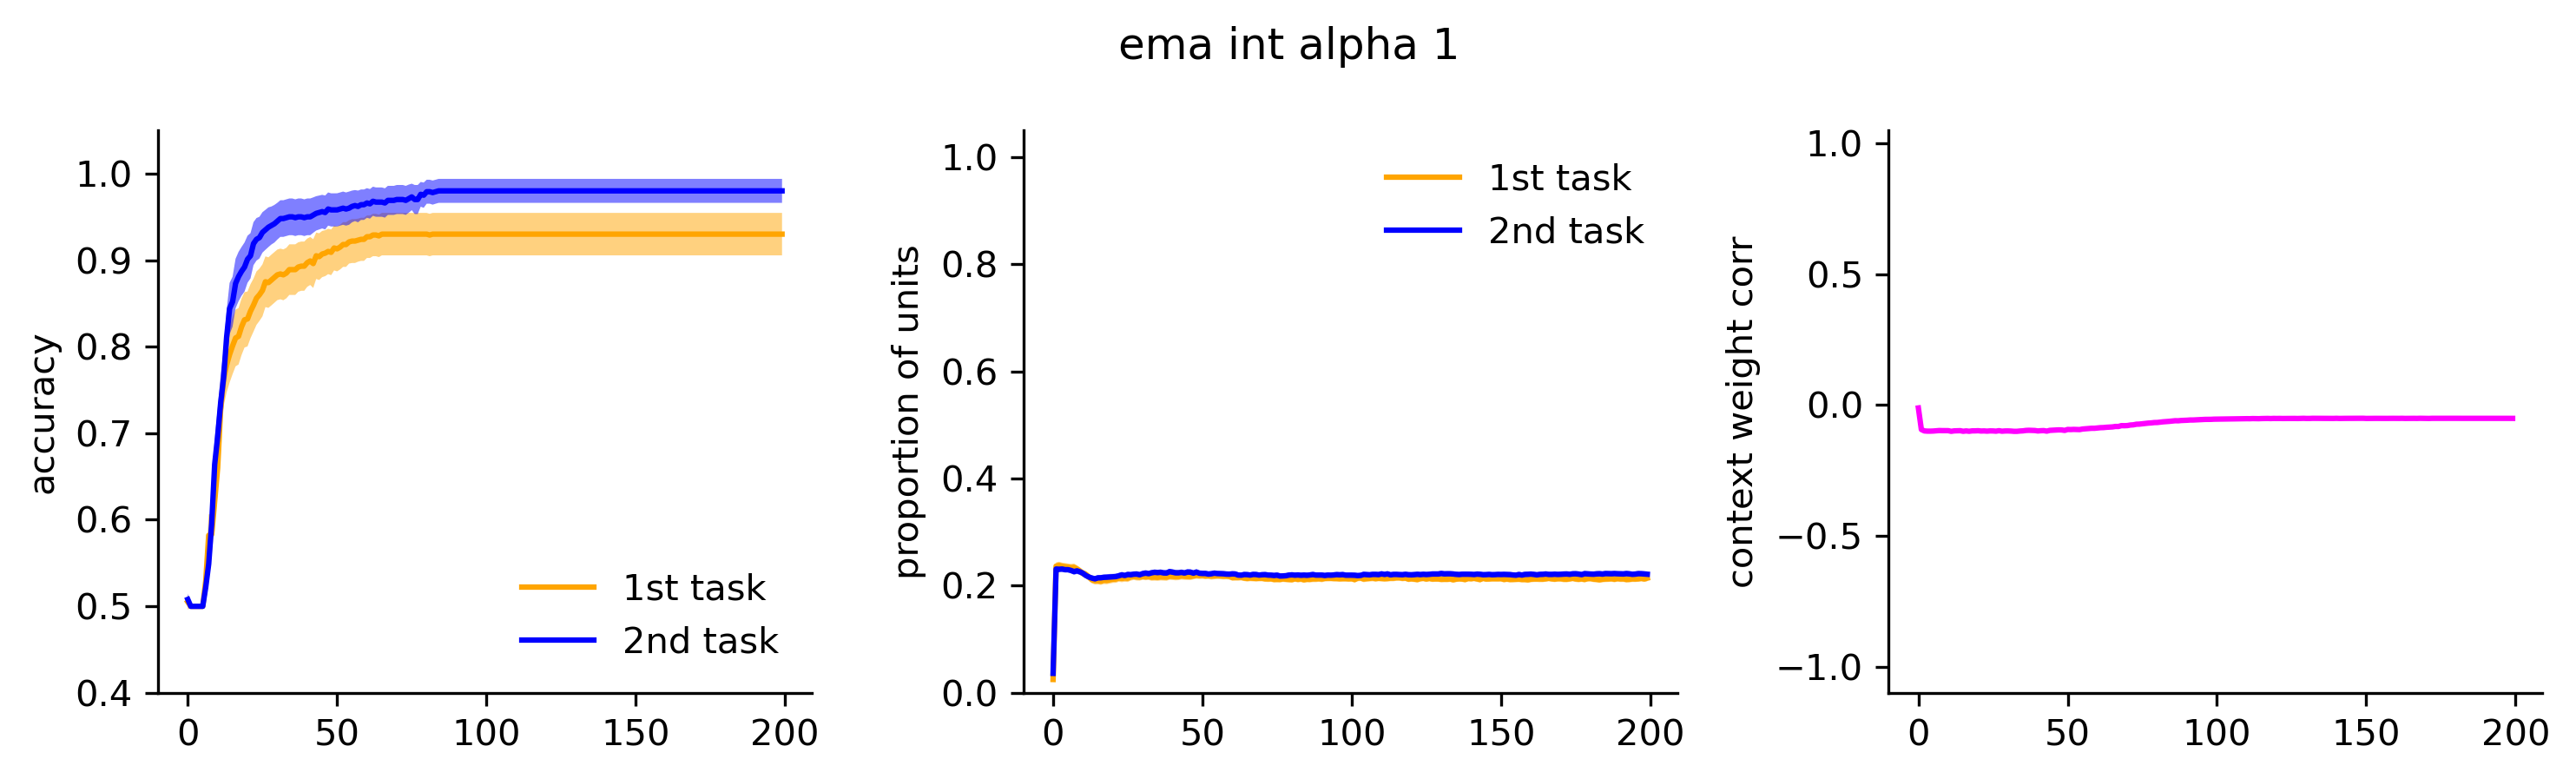

In [98]:
n_runs = 50
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alphas_to_plot = [0.05,0.1, 0.2, 0.3, 0.4, 0.7, 1]
idces = [np.where(alp==sluggish_vals)[0][0] for alp in alphas_to_plot]

for i,m in zip(idces,alphas_to_plot):
    f, axs = plt.subplots(1,3,figsize=(10,3),dpi=300)
    t_a = np.empty((n_runs,200))
    t_b = np.empty((n_runs,200))
    t_d = np.empty((n_runs,200))
    t_mixed = np.empty((n_runs,200))
    acc_1st = np.empty((n_runs,200))
    acc_2nd = np.empty((n_runs,200))
    contextcorr = np.empty((n_runs,200))

    for r in range(n_runs):
        with open('checkpoints/sluggish_sla_int_sv'+ str(i) + '/run_' + str(r) +'/results.pkl','rb') as f:
            results = pickle.load(f)
            t_a[r,:] = results['n_only_a']/100
            t_b[r,:] = results['n_only_b']/100
            t_d[r,:] = results['n_dead']/100
            t_mixed[r,:] = 1-t_a[r,:]-t_b[r,:]-t_d[r,:]
            if m=='gated_blocked':
                contextcorr[r,:] = [-1]*200
            else:
                contextcorr[r,:] = results['w_context_corr']
            acc_1st[r,:] = results['acc_1st']
            acc_2nd[r,:] = results['acc_2nd']
    
    axs[0].plot(np.arange(200),acc_1st.mean(0),color='orange')
    axs[0].fill_between(np.arange(200),acc_1st.mean(0)-np.std(acc_1st,0)/np.sqrt(n_runs),acc_1st.mean(0)+np.std(acc_1st,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
    axs[0].plot(np.arange(200),acc_2nd.mean(0),color='blue')
    axs[0].fill_between(np.arange(200),acc_2nd.mean(0)-np.std(acc_2nd,0)/np.sqrt(n_runs),acc_2nd.mean(0)+np.std(acc_2nd,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)
    axs[0].set_ylim([0.4,1.05])
    axs[0].set(ylabel='accuracy')
    axs[0].legend(['1st task','2nd task'],frameon=False)
    # axs[0].plot([100,100],[0,1],'k--',alpha=0.5)
    plt.suptitle('ema int alpha '+str(np.round(m,2)))
    sns.despine()


    axs[1].plot(np.arange(200),t_b.mean(0),color='orange')
    axs[1].fill_between(np.arange(200),t_b.mean(0)-np.std(t_b,0)/np.sqrt(n_runs),t_b.mean(0)+np.std(t_b,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
    axs[1].plot(np.arange(200),t_a.mean(0),color='blue')
    axs[1].fill_between(np.arange(200),t_a.mean(0)-np.std(t_a,0)/np.sqrt(n_runs),t_a.mean(0)+np.std(t_a,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)
    # axs[1].plot(np.arange(200),t_mixed.mean(0),color='darkgreen',linestyle='--')
    # axs[1].plot(np.arange(200),t_d.mean(0),color='red',linestyle='--')
    plt.suptitle('ema int alpha '+str(np.round(m,2)))
    axs[1].set_ylim([0,1.05])
    axs[1].set(ylabel='proportion of units')
    axs[1].legend(['1st task','2nd task'],frameon=False)
    # axs[1].plot([100,100],[0,1],'k--',alpha=0.5)
    sns.despine()

    axs[2].plot(np.arange(200),contextcorr.mean(0),color='magenta')    
    axs[2].fill_between(np.arange(200),contextcorr.mean(0)-np.std(contextcorr,0)/np.sqrt(n_runs),contextcorr.mean(0)+np.std(contextcorr,0)/np.sqrt(n_runs),alpha=0.5,color='magenta',edgecolor=None)
    plt.suptitle('ema int alpha '+str(np.round(m,2)))
    axs[2].set_ylim([-1.1,1.05])
    axs[2].set(ylabel='context weight corr')    
    # axs[2].plot([100,100],[-1,1],'k--',alpha=0.5)
    sns.despine()
    plt.tight_layout()


# SLA vs human data
* accuracy: humans, sla
* intrusions: humans, sla 
* choice matrices: humans, sla 
* parameterised model: humans, sla
* representations (quick MDS plot)

### Accuracy

Text(0.5, 0.98, 'Accuracy')

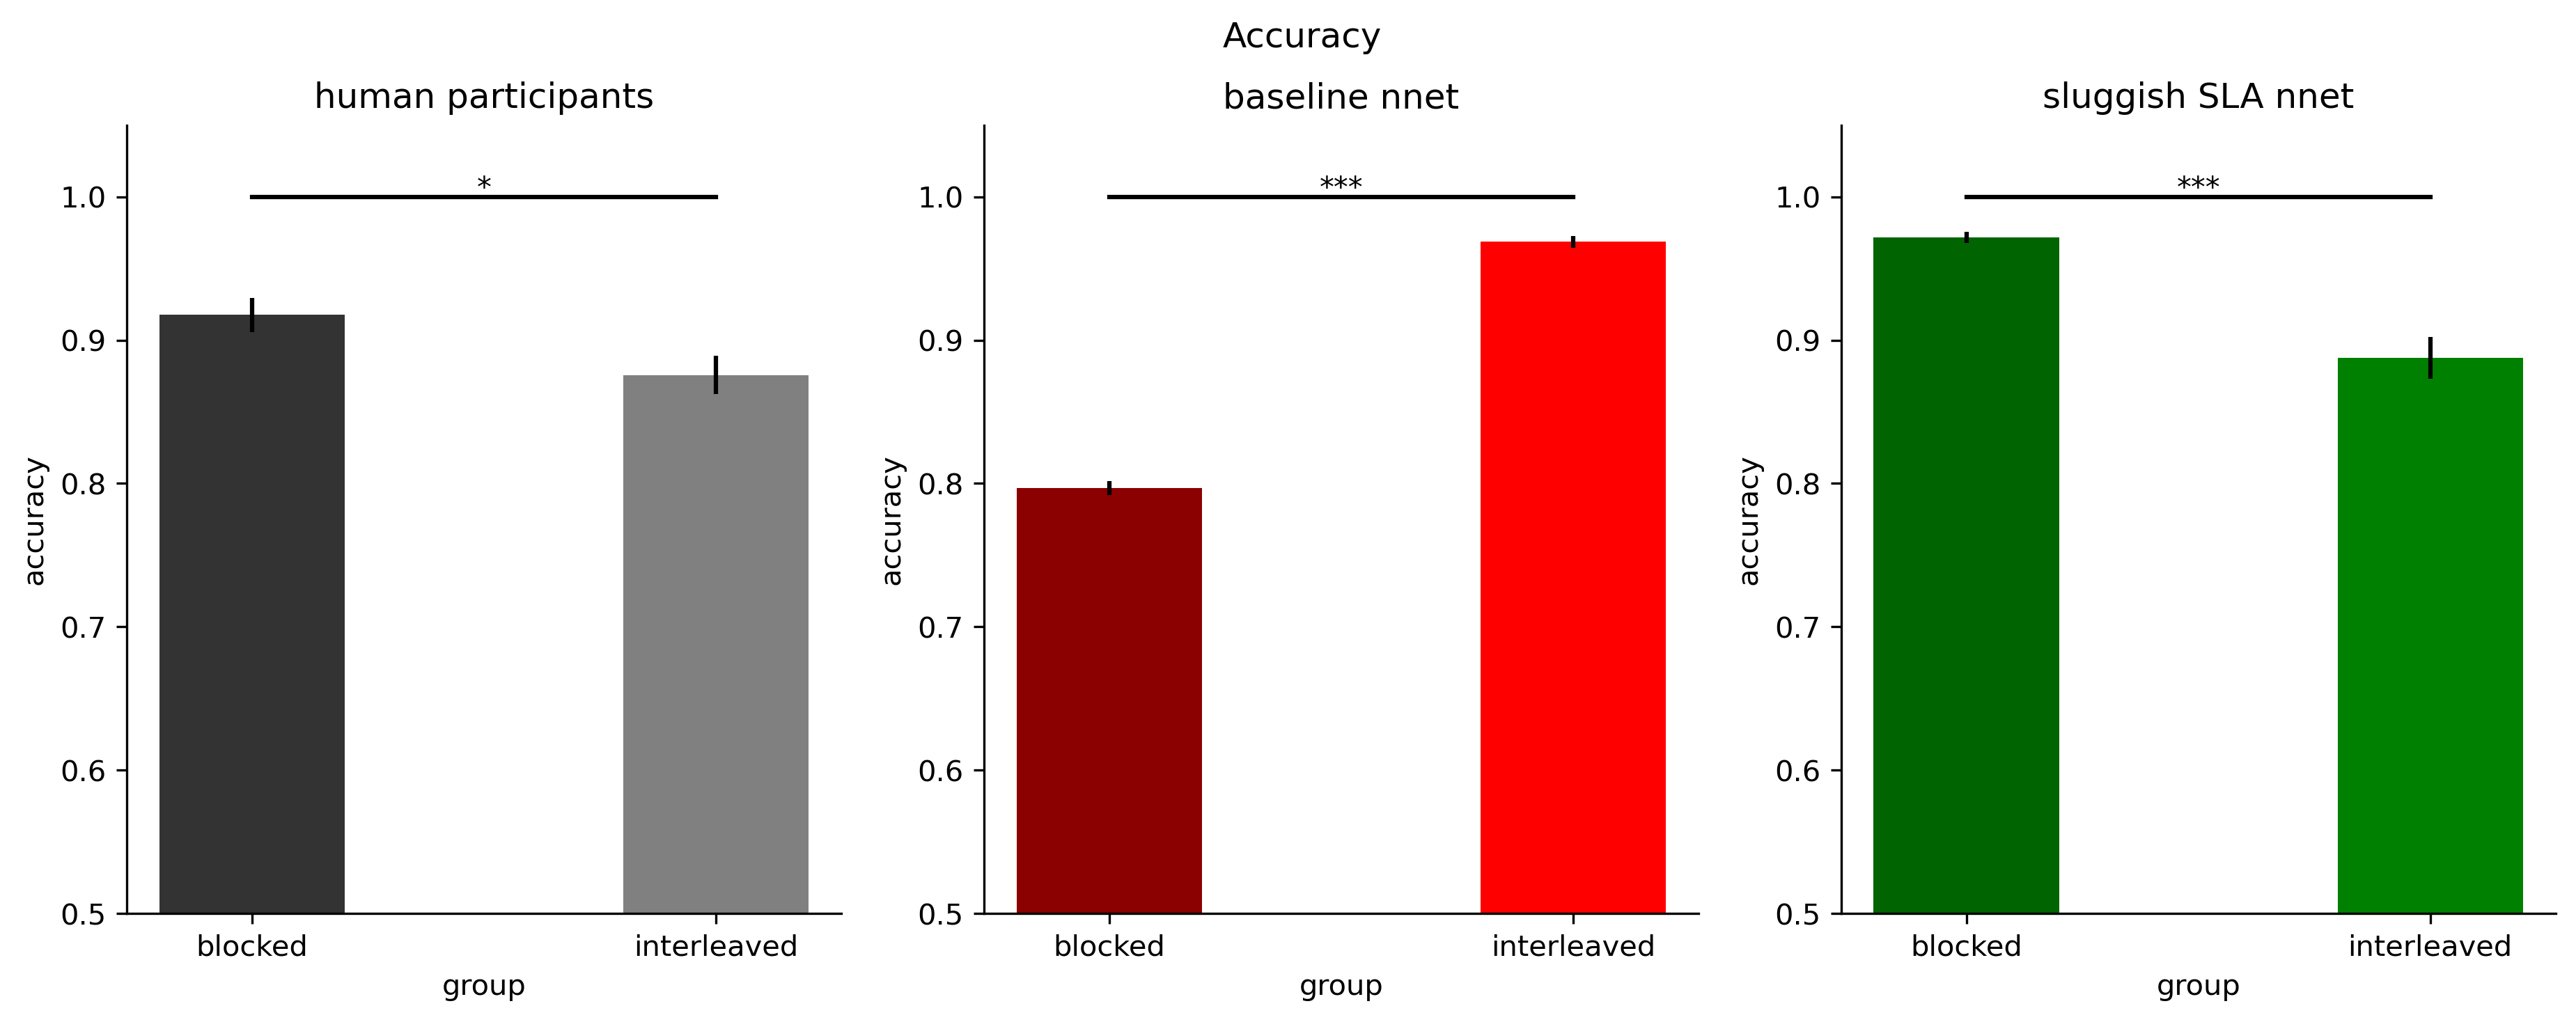

In [340]:
# bar plot with human data 
# error dots with sluggish sla network and baseline network 

#load slugglish sla int , collect accuracies
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alpha = 0.2
idx = np.where(sluggish_vals==alpha)[0][0]
n_runs = 50 
acc_a = []
acc_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/sluggish_baseline_int_sv'+ str(idx) + '/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        acc_a.append(results['acc_1st'][-1])
        acc_b.append(results['acc_2nd'][-1])
acc_int_sla = (np.array(acc_a)+np.array(acc_b))/2

# load sluggish sla blocked, collect accuracies
n_runs = 50 
acc_a = []
acc_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/sla_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        acc_a.append(results['acc_1st_noise'][-1][6])
        acc_b.append(results['acc_2nd_noise'][-1][6])
acc_blocked_sla = (np.array(acc_a)+np.array(acc_b))/2

# load baseline models:
n_runs = 50 
acc_a = []
acc_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/baseline_interleaved_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        acc_a.append(results['acc_1st_noise'][-1][6])
        acc_b.append(results['acc_2nd_noise'][-1][6])
acc_int_baseline = (np.array(acc_a)+np.array(acc_b))/2
n_runs = 50 
acc_a = []
acc_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/baseline_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        acc_a.append(results['acc_1st_noise'][-1][6])
        acc_b.append(results['acc_2nd_noise'][-1][6])
acc_blocked_baseline = (np.array(acc_a)+np.array(acc_b))/2




plt.figure(figsize=(15,5),dpi=300)
# make figure 
plt.subplot(1,3,1)
accs = loadmat('../data/pnas_paper/accs_exp1a.mat')
plt.bar(np.arange(2),[accs['acc_b200'].mean(),accs['acc_int'].mean()],yerr=[np.std(accs['acc_b200'])/np.sqrt(len(accs['acc_b200'].T)),np.std(accs['acc_int'])/np.sqrt(len(accs['acc_int'].T))],color=[[0.2,0.2,0.2],[0.5,0.5,0.5]],width=0.4)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=0)
plt.ylim(0.5,1.05)
plt.ylabel('accuracy')
plt.xlabel('group')
sns.despine()
# plt.legend([mod_bsl,mod_sla],['baseline nnet', 'sluggish SLA nnet'],frameon=False)
plt.title('human participants')
plt.plot([0,1],[1,1],'k-')
plt.text(0.5,1,'*',ha='center')

plt.subplot(1,3,2)
plt.bar(np.arange(2),[acc_blocked_baseline.mean(),acc_int_baseline.mean()],yerr=[np.std(acc_blocked_baseline)/np.sqrt(n_runs),np.std(acc_int_baseline)/np.sqrt(n_runs)],color=['darkred','red'],width=0.4)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=0)
plt.ylim(0.5,1.05)
plt.ylabel('accuracy')
plt.xlabel('group')
sns.despine()
plt.title('baseline nnet')
plt.plot([0,1],[1,1],'k-')
plt.text(0.5,1,'***',ha='center')

plt.subplot(1,3,3)
plt.bar(np.arange(2),[acc_blocked_sla.mean(),acc_int_sla.mean()],yerr=[np.std(acc_blocked_sla)/np.sqrt(n_runs),np.std(acc_int_sla)/np.sqrt(n_runs)],color=['darkgreen','green'],width=0.4)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=0)
plt.ylim(0.5,1.05)
plt.ylabel('accuracy')
plt.xlabel('group')
sns.despine()
plt.title('sluggish SLA nnet')
plt.plot([0,1],[1,1],'k-')
plt.text(0.5,1,'***',ha='center')
plt.suptitle('Accuracy')
# plt.tight_layout()

### Sigmoids

In [302]:
choices = loadmat('../data/pnas_paper/choices_exp1a.mat')


(48, 5)

Text(0.5, 0.98, 'Choices')

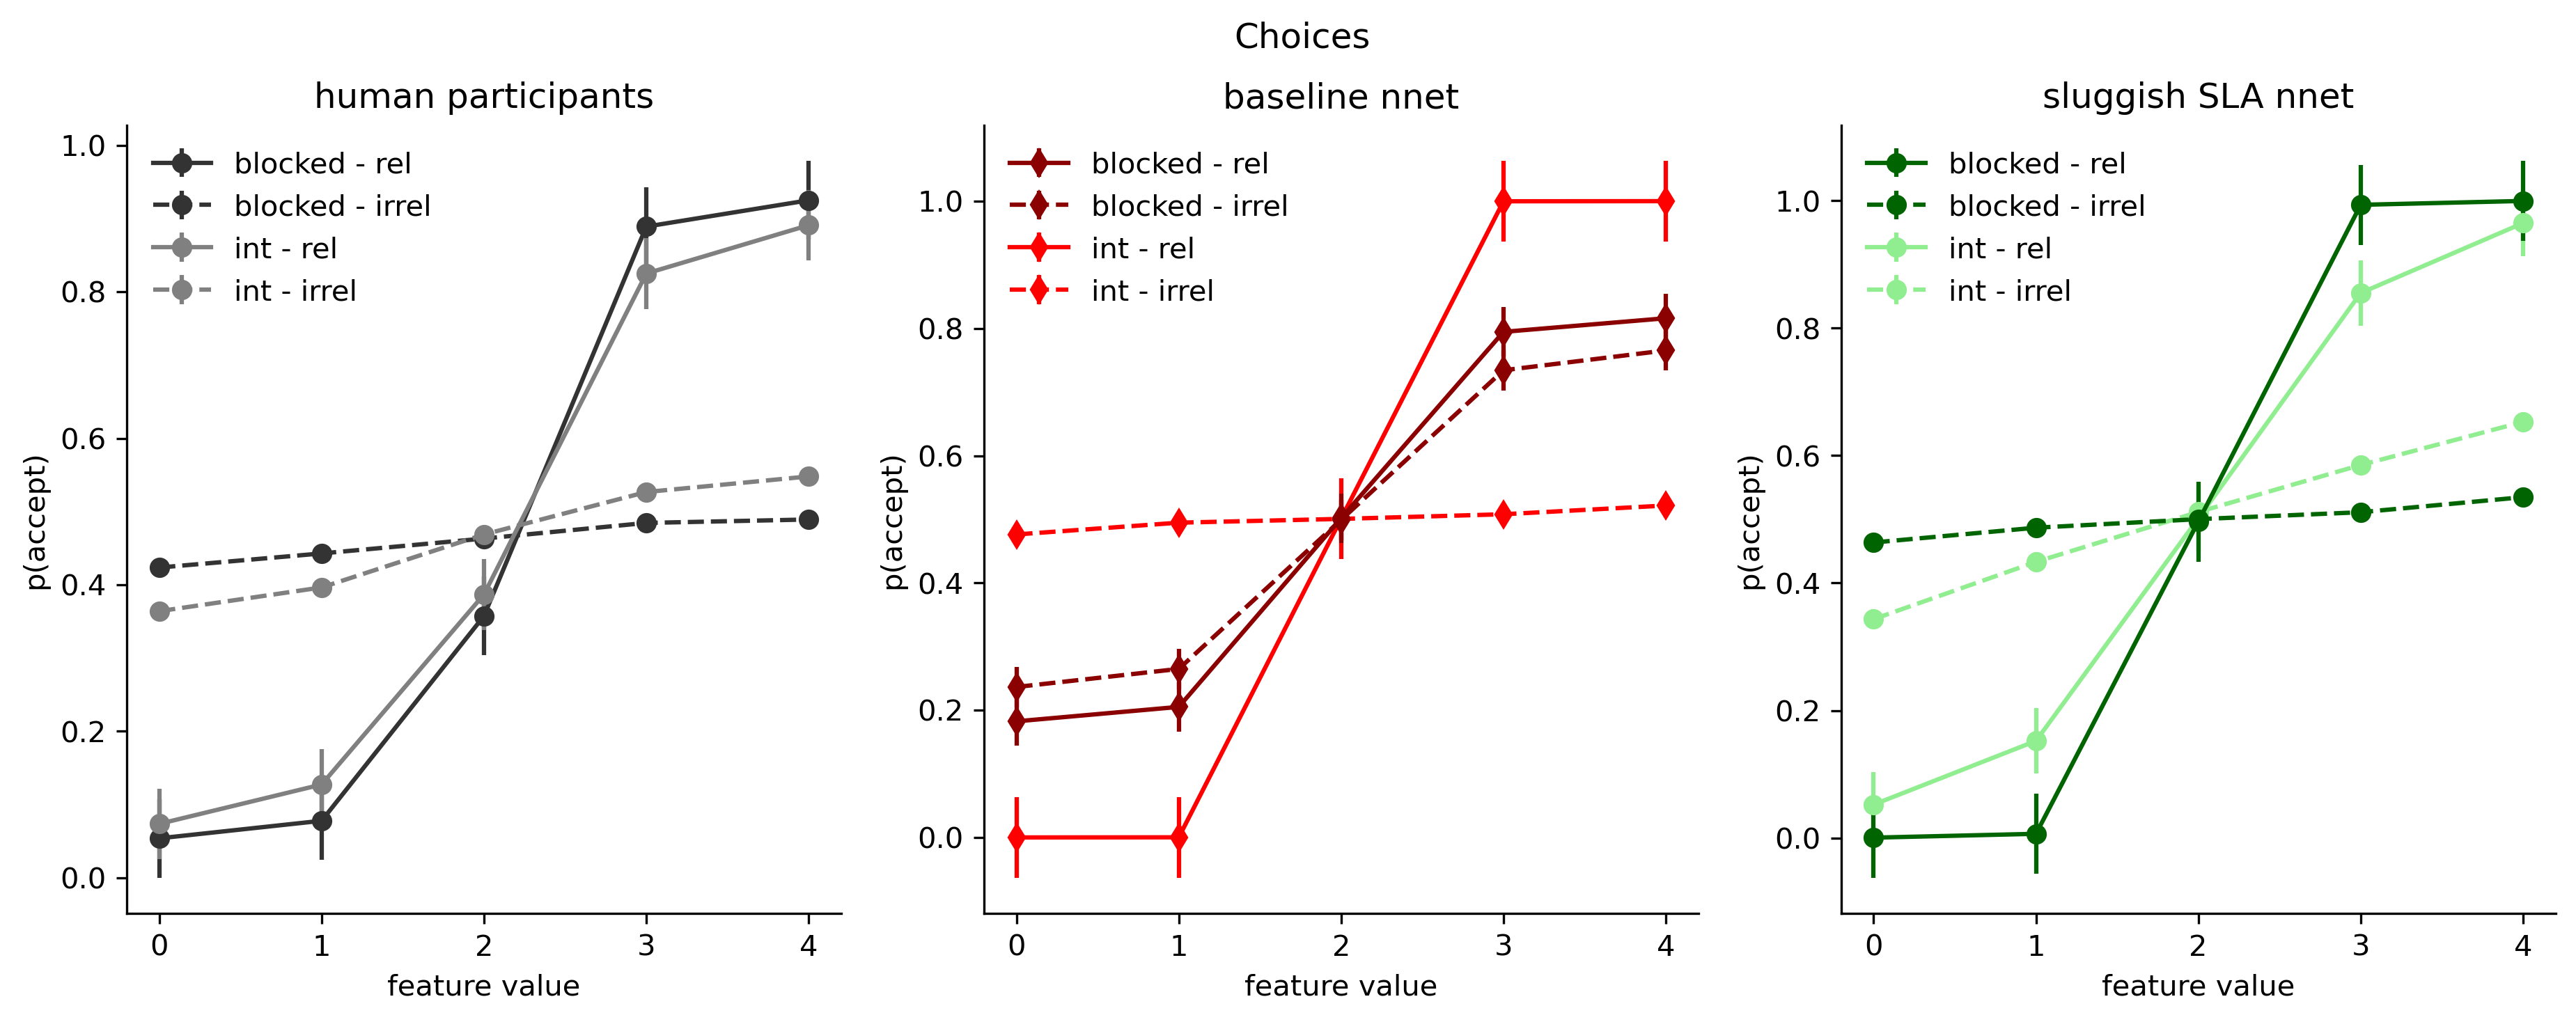

In [339]:
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alpha = 0.2
idx = np.where(alpha==sluggish_vals)[0][0]

n_runs = 50 
plt.figure(figsize=(15,5),dpi=300)



plt.subplot(1,3,1)
choices = loadmat('../data/pnas_paper/choices_exp1a.mat')
pl_bl_rel = plt.errorbar(np.arange(5),choices['choices_b200_rel'].mean(0),yerr=np.std(choices['choices_b200_rel'].mean(0))/np.sqrt(n_runs),marker='o',color=(0.2,0.2,0.2))
pl_bl_irrel = plt.errorbar(np.arange(5),choices['choices_b200_irrel'].mean(0),yerr=np.std(choices['choices_b200_irrel'].mean(0))/np.sqrt(n_runs),marker='o',color=(0.2,0.2,0.2),linestyle='--')

pl_in_rel = plt.errorbar(np.arange(5),choices['choices_int_rel'].mean(0),yerr=np.std(choices['choices_int_rel'].mean(0))/np.sqrt(n_runs),marker='o',color=(0.5,0.5,0.5))
pl_in_irrel = plt.errorbar(np.arange(5),choices['choices_int_irrel'].mean(0),yerr=np.std(choices['choices_int_irrel'].mean(0))/np.sqrt(n_runs),marker='o',color=(0.5,0.5,0.5),linestyle='--')

sns.despine()
plt.legend([pl_bl_rel,pl_bl_irrel,pl_in_rel,pl_in_irrel],['blocked - rel','blocked - irrel', 'int - rel', 'int - irrel'],frameon=False)
plt.title('human participants')
plt.xlabel('feature value')
plt.ylabel('p(accept)')



plt.subplot(1,3,2)
cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/baseline_interleaved_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)
choices_rel = (cmats_a.mean(2) + cmats_b.mean(1))/2
choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2))/2
pl_in_rel = plt.errorbar(np.arange(5),choices_rel.mean(0),yerr=np.std(choices_rel.mean(0))/np.sqrt(n_runs),marker='d',color='red')
pl_in_irrel = plt.errorbar(np.arange(5),choices_irrel.mean(0),yerr=np.std(choices_irrel.mean(0))/np.sqrt(n_runs),marker='d',color='red',linestyle='--')
cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/baseline_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)
choices_rel = (cmats_a.mean(2) + cmats_b.mean(1))/2
choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2))/2
pl_bl_rel = plt.errorbar(np.arange(5),choices_rel.mean(0),yerr=np.std(choices_rel.mean(0))/np.sqrt(n_runs),marker='d',color='darkred')
pl_bl_irrel = plt.errorbar(np.arange(5),choices_irrel.mean(0),yerr=np.std(choices_irrel.mean(0))/np.sqrt(n_runs),marker='d',color='darkred',linestyle='--')
plt.legend([pl_bl_rel,pl_bl_irrel,pl_in_rel,pl_in_irrel],['blocked - rel','blocked - irrel', 'int - rel', 'int - irrel'],frameon=False)
plt.title('baseline nnet')
plt.xlabel('feature value')
plt.ylabel('p(accept)')


plt.subplot(1,3,3)
cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/sluggish_baseline_int_sv'+ str(idx) + '/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)
choices_rel = (cmats_a.mean(2) + cmats_b.mean(1))/2
choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2))/2
pl_in_rel = plt.errorbar(np.arange(5),choices_rel.mean(0),yerr=np.std(choices_rel.mean(0))/np.sqrt(n_runs),marker='o',color='lightgreen')
pl_in_irrel = plt.errorbar(np.arange(5),choices_irrel.mean(0),yerr=np.std(choices_irrel.mean(0))/np.sqrt(n_runs),marker='o',color='lightgreen',linestyle='--')
cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/sla_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)
choices_rel = (cmats_a.mean(2) + cmats_b.mean(1))/2
choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2))/2
pl_bl_rel = plt.errorbar(np.arange(5),choices_rel.mean(0),yerr=np.std(choices_rel.mean(0))/np.sqrt(n_runs),marker='o',color='darkgreen')
pl_bl_irrel = plt.errorbar(np.arange(5),choices_irrel.mean(0),yerr=np.std(choices_irrel.mean(0))/np.sqrt(n_runs),marker='o',color='darkgreen',linestyle='--')
sns.despine()
plt.legend([pl_bl_rel,pl_bl_irrel,pl_in_rel,pl_in_irrel],['blocked - rel','blocked - irrel', 'int - rel', 'int - irrel'],frameon=False)
plt.title('sluggish SLA nnet')
plt.xlabel('feature value')
plt.ylabel('p(accept)')
plt.suptitle('Choices')
# plt.tight_layout()

dict_keys(['__header__', '__version__', '__globals__', 'cmat_b_north', 'cmat_b_south', 'cmat_i_north', 'cmat_i_south'])

### choice model

In [378]:
def sigmoid(x,L,k,x0):
    '''
    sigmoidal nonlinearity with three free parameters (lapse, slope, offset)
    '''
    
    y = L + (1-L*2) / (1. + np.exp(-k*(x-x0)))
    return y


def scalar_projection(X,phi):
    '''
    performs scalar projection of x onto y by angle phi
    '''
    phi_bound = np.deg2rad(phi)
    phi_ort = phi_bound-np.deg2rad(90)
    y = X @ np.array([np.cos(phi_ort),np.sin(phi_ort)]).T
    return y


def angular_distance(target_ang,source_ang):
    target_ang = np.deg2rad(target_ang)
    source_ang = np.deg2rad(source_ang)
    return np.rad2deg(np.arctan2(np.sin(target_ang-source_ang), np.cos(target_ang-source_ang)))


def angular_bias(ref,est,task='a'):
    bias = angular_distance(est,ref)
    if task=='a':
        bias = -bias
    return bias


def objective_function(X,y_true):

    def loss(theta):        
        return -np.sum(np.log(1.-np.abs(y_true-choice_model(X, theta))+1e-5 ))
    return loss 


def choice_model(X,theta):
    '''
    generates choice probability matrix 
    free parameters: orientation of bound, slope, offset and lapse rate of sigmoidal transducer
    '''
    # projection task a
    X1 = scalar_projection(X,theta[0])
    # projection task b
    X2 = scalar_projection(X,theta[1])

    # inputs to model
    X_in = np.concatenate((X1,X2))

    # pass through transducer:
    y_hat = sigmoid(X_in,theta[2],theta[3],theta[4])
    
    # return outputs
    return y_hat


def fit_choice_model(y_true):
    '''
    fits choice model to data, using Nelder-Mead or L-BFGS-B algorithm
    '''
    a,b = np.meshgrid(np.arange(-2,3),np.arange(-2,3))
    a = a.flatten()
    b = b.flatten()
    X = np.stack((a,b)).T
    theta_init = [90,180,0,10,0]
    theta_bounds = ((0,360),(0,360),(0,0.5),(0,20),(-1,1))
    results = minimize(objective_function(X,y_true),theta_init,bounds=theta_bounds,method='L-BFGS-B')

    return results.x


def fit_model_to_subjects(choicemats):
    '''
    wrapper for fit_choice_model
    loops over subjects
    '''
    tasks = ['task_a','task_b']

    thetas = {'bias_a':[],'bias_b':[],'lapse':[],'slope':[],'offset':[]}
    for sub in range(len(choicemats[tasks[0]])):
        cmat_a = choicemats[tasks[0]][sub,:,:]
        cmat_b = choicemats[tasks[1]][sub,:,:]
        cmats = np.concatenate((cmat_a.flatten(),cmat_b.flatten()))
        theta_hat = fit_choice_model(cmats)
        theta_hat[0] = angular_bias(theta_hat[0],90,task='a')
        theta_hat[1] = angular_bias(theta_hat[1],180,task='b')
        for idx,k in enumerate(thetas.keys()):
            thetas[k].append(theta_hat[idx])
    for k in thetas.keys():
        thetas[k] = np.asarray(thetas[k])
    thetas['bias'] = np.stack((thetas['bias_a'],thetas['bias_b']),axis=1).mean(1)
    return thetas

def disp_model_estimates(thetas):
    '''
    displays average parameter estimates of choice model
    '''
    sem = lambda x,ax: np.nanstd(x,ddof=1,axis=ax) / np.sqrt(np.shape(x)[ax])
    parameters = ['bias','lapse', 'slope','offset']
    curricula = ['blocked','interleaved']
    cols = [[0.2,0.2,0.2],[.6,.6,.6]]

    plt.figure(figsize=(15,5))

    for ii,param in enumerate(parameters):
        # average parameter estimates across tasks (orange/blue)
        p_blocked = thetas['blocked'][param]
        p_interleaved = thetas['interleaved'][param]
        # bar plots with errorbars
        plt.subplot(1,4,ii+1)
        ax = plt.gca()
        ax.bar(0,p_blocked.mean(),yerr=sem(p_blocked,0),color=cols[0],zorder=1)
        ax.bar(1,p_interleaved.mean(),yerr=sem(p_interleaved,0),color=cols[1],zorder=1)

        _,pval = stats.mannwhitneyu(p_blocked,p_interleaved)
        ax.set(xticks=[0,1],xticklabels=('blocked','interleaved'),ylabel='parameter estimate (a.u)',title=param + ', p=' + str(np.round(pval,4)))
        sns.despine()

    plt.tight_layout()


In [379]:
cmats = loadmat('../data/pnas_paper/choicemats_exp1a.mat')
cmats.keys()
choicemats_humans = {
    'blocked': 
    {
        'task_a':cmats['cmat_b_south'], 
        'task_b':cmats['cmat_b_north']
    },
    'interleaved': 
    {
        'task_a':cmats['cmat_i_south'], 
        'task_b':cmats['cmat_i_north']
    }
}


choicemats_baseline = {
    'blocked': 
    {
        'task_a':[], 
        'task_b':[]
    },
    'interleaved': 
    {
        'task_a':[], 
        'task_b':[]
    }
}


choicemats_sla = {
    'blocked': 
    {
        'task_a':[], 
        'task_b':[]
    },
    'interleaved': 
    {
        'task_a':[], 
        'task_b':[]
    }
}

## baseline --------------------------------
n_runs = 50 

cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/baseline_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
choicemats_baseline['blocked']['task_b'] = np.array(cmats_a)
choicemats_baseline['blocked']['task_a'] = np.array(cmats_b)

cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/baseline_interleaved_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
choicemats_baseline['interleaved']['task_b'] = np.array(cmats_a)
choicemats_baseline['interleaved']['task_a'] = np.array(cmats_b)

## sla ------------------------------------------
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alpha = 0.2
idx = np.where(alpha==sluggish_vals)[0][0]
cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/sla_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
choicemats_sla['blocked']['task_b'] = np.array(cmats_a)
choicemats_sla['blocked']['task_a'] = np.array(cmats_b)

cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/sluggish_baseline_int_sv'+ str(idx) +'/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
choicemats_sla['interleaved']['task_b'] = np.array(cmats_a)
choicemats_sla['interleaved']['task_a'] = np.array(cmats_b)

In [380]:
thetas_humans = {}
for cur in ['blocked','interleaved']:
    thetas_humans[cur] = fit_model_to_subjects(choicemats_humans[cur])

thetas_baseline = {}
for cur in ['blocked','interleaved']:
    thetas_baseline[cur] = fit_model_to_subjects(choicemats_baseline[cur])

thetas_sla = {}
for cur in ['blocked','interleaved']:
    thetas_sla[cur] = fit_model_to_subjects(choicemats_sla[cur])

In [394]:
# disp_model_estimates(thetas_humans)
# disp_model_estimates(thetas_baseline)
# disp_model_estimates(thetas_sla)

In [389]:
[np.std(thetas_baseline['blocked']['bias'])/np.sqrt(n_runs),np.std(thetas_baseline['interleaved']['bias'])/np.sqrt(n_runs)]

[1.3176625634223946, 0.22532659740705346]

Text(0.5, 0.98, 'Angular Bias of Decision Boundary')

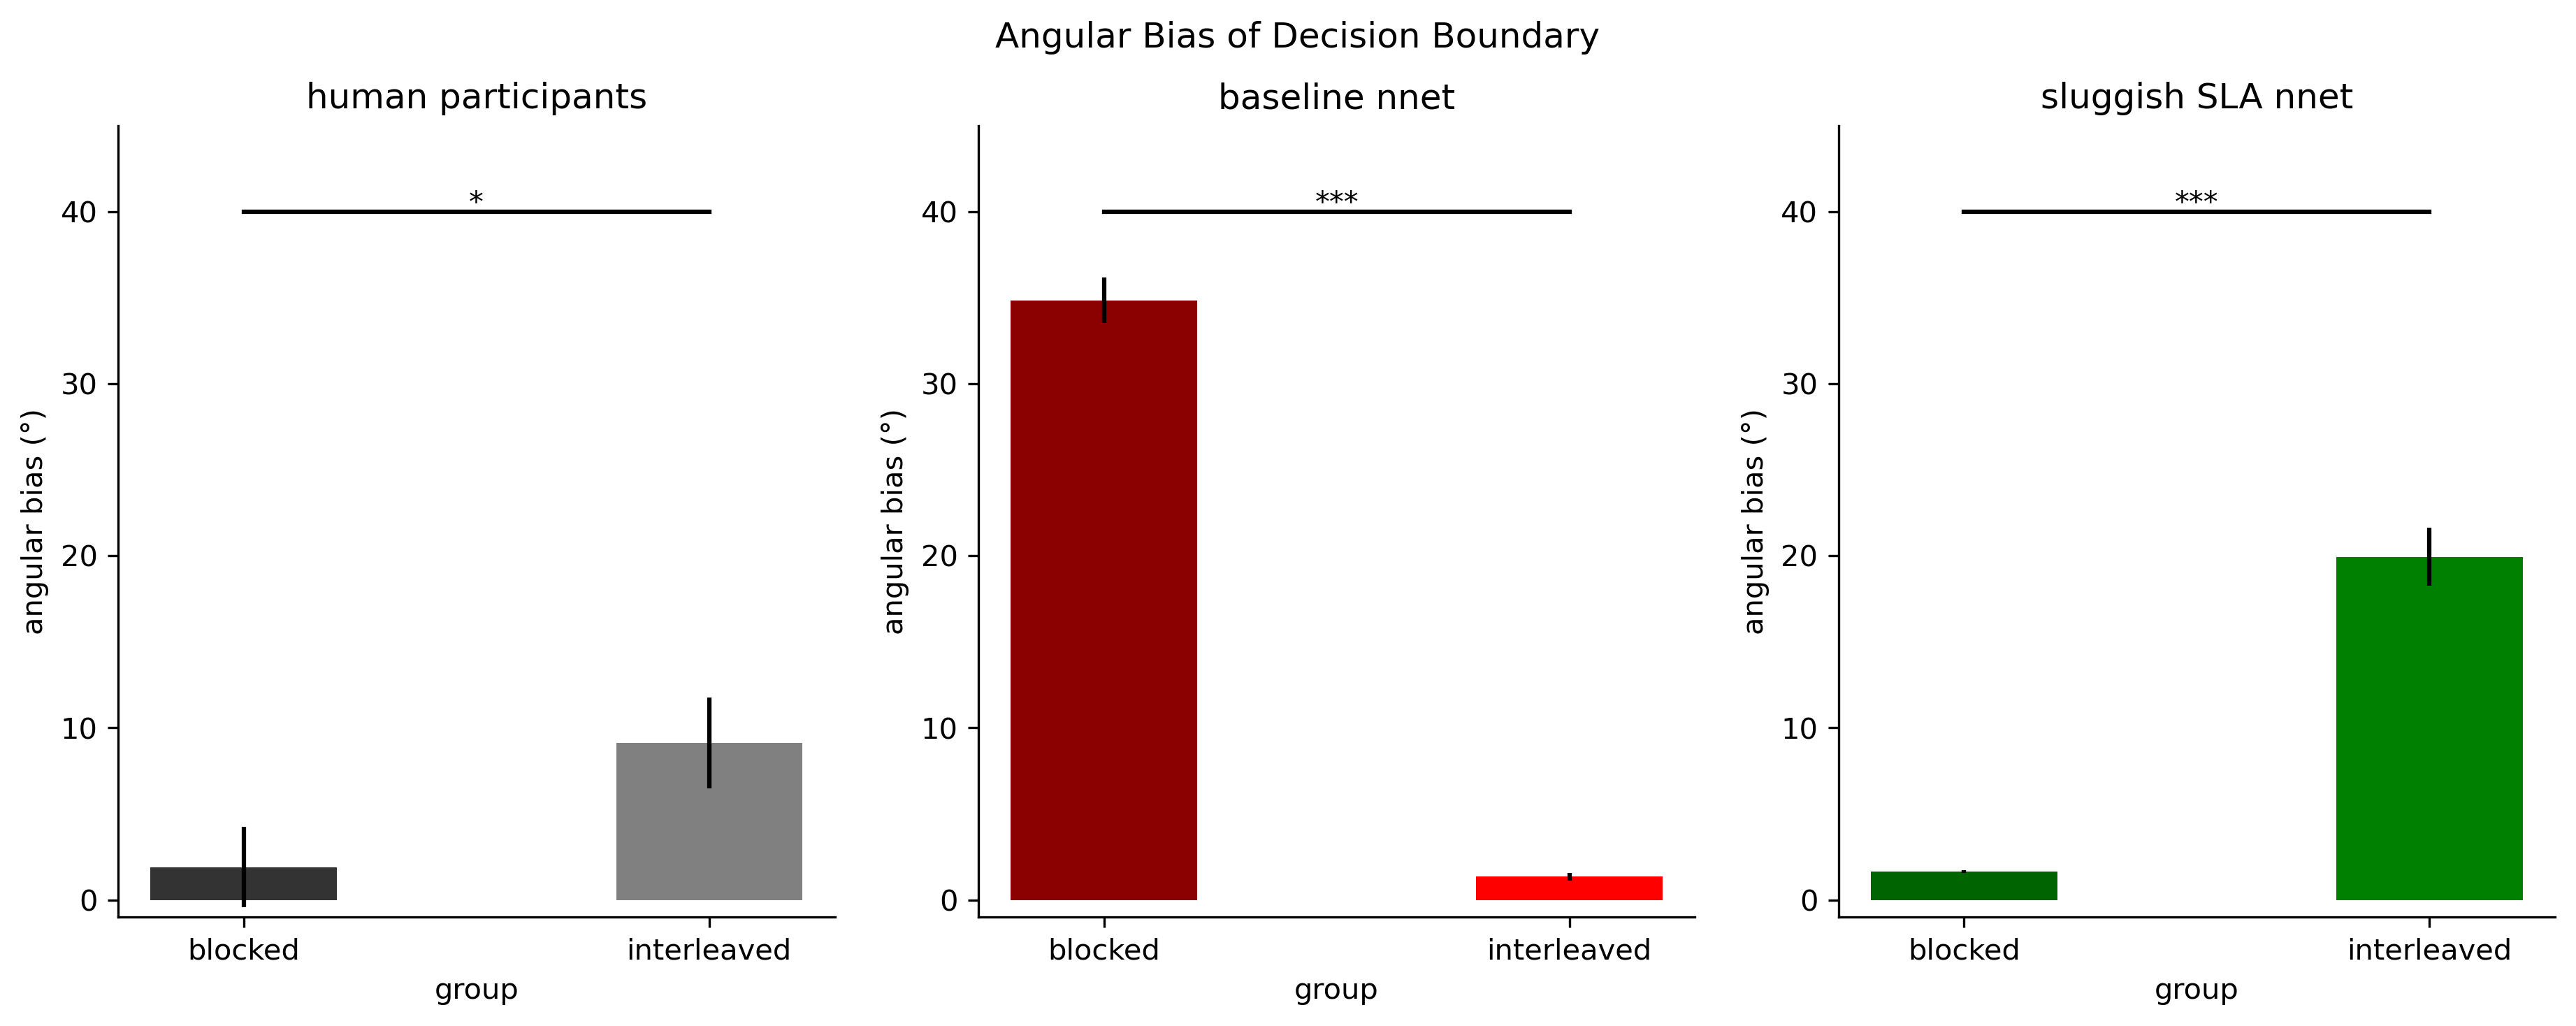

In [393]:

plt.figure(figsize=(15,5),dpi=300)
# make figure 
plt.subplot(1,3,1)

plt.bar(np.arange(2),[thetas_humans['blocked']['bias'].mean(),thetas_humans['interleaved']['bias'].mean()],yerr=[np.std(thetas_humans['blocked']['bias'])/np.sqrt(len(thetas_humans['blocked']['bias'].T)),np.std(thetas_humans['interleaved']['bias'])/np.sqrt(len(thetas_humans['interleaved']['bias'].T))],color=[[0.2,0.2,0.2],[0.5,0.5,0.5]],width=0.4)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=0)
plt.ylim(-1,45)
plt.ylabel('angular bias (°)')
plt.xlabel('group')
sns.despine()
plt.title('human participants')
plt.plot([0,1],[40,40],'k-')
plt.text(0.5,40,'*',ha='center')

plt.subplot(1,3,2)
plt.bar(np.arange(2),[thetas_baseline['blocked']['bias'].mean(),thetas_baseline['interleaved']['bias'].mean()],yerr=[np.std(thetas_baseline['blocked']['bias'])/np.sqrt(n_runs),np.std(thetas_baseline['interleaved']['bias'])/np.sqrt(n_runs)],color=['darkred','red'],width=0.4)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=0)
plt.ylim(-1,45)
plt.ylabel('angular bias (°)')
plt.xlabel('group')
sns.despine()
plt.title('baseline nnet')
plt.plot([0,1],[40,40],'k-')
plt.text(0.5,40,'***',ha='center')

plt.subplot(1,3,3)
plt.bar(np.arange(2),[thetas_sla['blocked']['bias'].mean(),thetas_sla['interleaved']['bias'].mean()],yerr=[np.std(thetas_sla['blocked']['bias'])/np.sqrt(n_runs),np.std(thetas_sla['interleaved']['bias'])/np.sqrt(n_runs)],color=['darkgreen','green'],width=0.4)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=0)
plt.ylim(-1,45)
plt.ylabel('angular bias (°)')
plt.xlabel('group')
sns.despine()
plt.title('sluggish SLA nnet')
plt.plot([0,1],[40,40],'k-')
plt.text(0.5,40,'***',ha='center')
plt.suptitle('Angular Bias of Decision Boundary')
# plt.tight_layout()